In [1]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from agent import *
from selection import *
from utils import *
from env import Environment, StochasticGameEnvironment
from simulation import *
from main import Config
from tqdm import tqdm
import seaborn as sns
import matplotlib.patheffects as path_effects

In [2]:
seed_everything()
config = {
    'reward': 3, 
    'sucker': 0, 
    'temptation': 5, 
    'punishment': 1, 
    'n_episodes': 10000, 
    'discount': 0.99,
    'play_epsilon': 1,
    'select_epsilon': 1,
    'epsilon_decay': 0.999,
    'min_epsilon': 0.01,
    'alpha': 0.1,
    'n_actions': 2,
    'h': 2,
    'select_h': 5,
    'state_repr': 'bi',
    'batch_size': 64,
    'learning_rate': 1e-3,
}

In [3]:
# strategies = {0:'ALLC',1:'ALLD',2:'TitForTat',3:'revTitForTat',4:'Random',5:'Grudger',6:'Pavlov',7:'QLearning',8:'LSTM',9:'DQN',10:'LSTMQN',11:'A2C',12:'A2CLSTM'}

# # h = [1,2,5,10]
# # epsilon_decay = [0.95, 0.99, 0.995, 0.999]

# h = [10]
# epsilon_decay = [0.995]

# config = {
#     'reward': 3, 
#     'sucker': 0, 
#     'temptation': 5, 
#     'punishment': 1, 
#     'n_episodes': 10000, 
#     'discount': 0.99,
#     'play_epsilon': 1,
#     'select_epsilon': 1,
#     'epsilon_decay': 0.999,
#     'min_epsilon': 0.01,
#     'alpha': 0.1,
#     'n_actions': 2,
#     'h': 10,
#     'state_repr': 'bi',
#     'batch_size': 64,
#     'learning_rate': 1e-3,
# }

# epsilon_dict = {'epsilon_decay=0.95':[],'epsilon_decay=0.99':[],'epsilon_decay=0.995':[],'epsilon_decay=0.999':[]}
# result_dict={'h=1':{}, 'h=2':{}, 'h=5':{}, 'h=10':{}}
# loss_dict={'h=1':{}, 'h=2':{}, 'h=5':{}, 'h=10':{}}
# strategy_dict={'h=1':{}, 'h=2':{}, 'h=5':{}, 'h=10':{}}
                
# for key in result_dict:
#     result_dict[key] = copy.deepcopy(epsilon_dict)
#     loss_dict[key] = copy.deepcopy(epsilon_dict)
#     strategy_dict[key] = copy.deepcopy(epsilon_dict)
    
# for i in h:
#     for j in epsilon_decay:
#         config['h'] = i
#         config['epsilon_decay'] = j
#         config_obj = Config(config)
#         env = Environment(config_obj)
#         print(f'config: h={i}, epsilon_decay={j}')
        
#         num = 10
#         rl_num = 10
#         for _ in range(1):
#             convergence = False
#             # twoSimulate(dict({num: strategies[num],rl_num: strategies[rl_num]}), rl_num, config)
#             with HiddenPrints():
#                 agent1 = constructAgent(strategies[num], config_obj)
#                 agent2 = constructAgent(strategies[rl_num], config_obj)

#                 k = 1000
#                 count = 0
#                 test_state_list = generate_state(agent1, i, 2, k)
#                 test_q_dict = {'agent1': {}, 'agent2': {}}
#                 while not convergence:
#                     twoSimulateAlter(agent1, agent2, config_obj, env, k)
#                     test_q_agent1_list = []
#                     test_q_agent2_list = []
#                     agent1.PolicyNet.eval()
#                     agent2.PolicyNet.eval()
                    
#                     for test_state in test_state_list:
#                         test_q_agent1 = agent1.PolicyNet(test_state[None])
#                         test_q_agent1_list.append(test_q_agent1.to('cpu').detach().numpy())
                        
#                         test_q_agent2 = agent2.PolicyNet(test_state[None])
#                         test_q_agent2_list.append(test_q_agent2.to('cpu').detach().numpy())
                        
#                     agent1.PolicyNet.train()
#                     agent2.PolicyNet.train()
                    
#                     test_q_dict['agent1'][count] = test_q_agent1_list
#                     test_q_dict['agent2'][count] = test_q_agent2_list
                    
#                     count += 1
#                     if agent2.play_times >= 100*k:
#                         break
        
# #                 result_dict[f'h={i}'][f'epsilon_decay={j}'].append(agent2.play_times)
# #                 loss_dict[f'h={i}'][f'epsilon_decay={j}'].append(np.mean(agent2.loss))
# #                 strategy_dict[f'h={i}'][f'epsilon_decay={j}'].append(list(agent2.own_memory[agent2.play_times-10:agent2.play_times]))
# #         print(f'playing times: {agent2.play_times}')
# #         print(f'length of loss: {len(agent2.loss)}, average of loss (interval is 2): {np.mean(agent2.loss[::2])}, average of loss (interval is 20): {np.mean(agent2.loss[::20])}, average of loss (interval is 100): {np.mean(agent2.loss[::100])}')
# #         agent2.show()
# #         print()
# #         print()

In [3]:
reward, temptation, sucker, punishment = generate_payoff_matrix('PD', N=100)

df_result = pd.DataFrame(columns=['strategy_convergent_episode', 'network_convergent_episode', 
                                  'temptation', 'reward', 'punishment', 'sucker', 'final_strategy', 'defection_ratio'])
for idx, val in tqdm(enumerate(reward)):
    config['h'] = 2
    config['n_episodes'] = 50000  # convergent threshold
    config['epsilon_decay'] = 0.995
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        agent, strategy_convergent_episode, network_convergent_episode, _ = TwoAgentSimulation.benchmark_episodic('LSTMQN', config_obj, episodic_flag=True)
#     agent.show()
    df_result.loc[len(df_result.index)] = [strategy_convergent_episode, network_convergent_episode, 
                                           config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                           round(float(torch.sum(agent.own_memory[agent.play_times-100:agent.play_times])/100)),
                                           float(torch.sum(agent.own_memory)/agent.play_times)]

df_result

100it [2:25:00, 87.01s/it]


,strategy_convergent_episode,network_convergent_episode,temptation,reward,punishment,sucker,final_strategy,defection_ratio
0,37565.0,39830.0,1.01,1.0,0.0,-0.63,1.0,0.898895
1,18091.0,19848.0,1.60,1.0,0.0,-0.06,1.0,0.814289
2,15710.0,17781.0,1.27,1.0,0.0,-0.28,1.0,0.851752
3,17485.0,19848.0,1.62,1.0,0.0,-0.41,1.0,0.860238
4,29807.0,41583.0,2.65,1.0,0.0,-0.85,1.0,0.950148
...,...,...,...,...,...,...,...,...
95,29807.0,NaN,1.40,1.0,0.0,-0.51,1.0,0.941702
96,29807.0,34093.0,2.02,1.0,0.0,-0.48,1.0,0.908720
97,29807.0,NaN,2.39,1.0,0.0,-0.58,1.0,0.958111
98,29807.0,41583.0,2.72,1.0,0.0,-0.97,1.0,0.950148


In [65]:
# sum(df_result['network_convergent_episode'].isnull())
sum(df_result['strategy_convergent_episode'].isnull())

0

In [13]:
pd.set_option('display.max_rows', None)
df_result.loc[df_result['strategy_convergent_episode'] >= 50000, 'strategy_convergent_episode'] = np.nan
df_result.loc[df_result['network_convergent_episode'] >= 50000, 'network_convergent_episode'] = np.nan
df_result['R+S-T-P'] = df_result['reward'] + df_result['sucker'] - df_result['temptation'] - df_result['punishment']
df_result.loc[df_result['network_convergent_episode'].isnull()]
# df_result.loc[df_result['network_convergent_episode'].isnull(), 'network_convergent_episode'] = 50000

,strategy_convergent_episode,network_convergent_episode,temptation,reward,punishment,sucker,final_strategy,defection_ratio,R+S-T-P
6,29807.0,NaN,1.68,1.0,0.0,-0.94,1.0,0.956516,-1.62
12,29807.0,NaN,2.07,1.0,0.0,-0.18,1.0,0.926948,-1.25
14,29807.0,NaN,2.08,1.0,0.0,-0.82,1.0,0.958111,-1.90
15,29807.0,NaN,2.55,1.0,0.0,-0.82,1.0,0.958111,-2.37
16,29807.0,NaN,2.32,1.0,0.0,-0.70,1.0,0.958111,-2.02
18,29807.0,NaN,2.37,1.0,0.0,-0.57,1.0,0.958111,-1.94
19,29807.0,NaN,1.83,1.0,0.0,-0.71,1.0,0.943177,-1.54
29,29807.0,NaN,1.90,1.0,0.0,-0.95,1.0,0.958111,-1.85
53,29807.0,NaN,1.44,1.0,0.0,-0.11,1.0,0.941203,-0.55
57,29807.0,NaN,2.33,1.0,0.0,-0.81,1.0,0.958111,-2.14


(-3.0, 0.0)

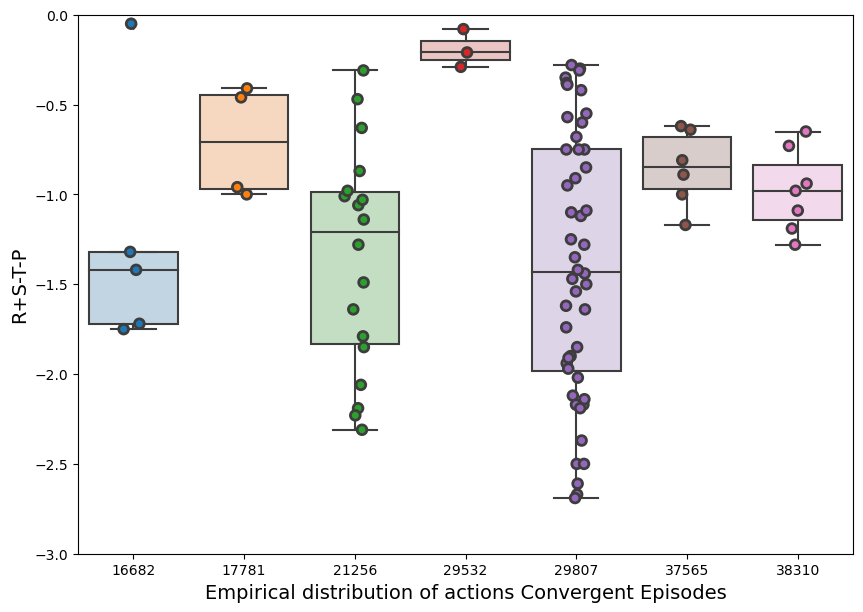

In [170]:
df_result.loc[df_result['strategy_convergent_episode'].isnull(), 'strategy_convergent_episode'] = np.inf
df_result.loc[df_result['network_convergent_episode'] >= 50000, 'network_convergent_episode'] = np.nan
df_result.loc[df_result['network_convergent_episode'].isnull(), 'network_convergent_episode'] = np.inf

df_plot = df_result.copy()
df_plot = df_plot[df_plot['strategy_convergent_episode'].map(df_plot['strategy_convergent_episode'].value_counts()) > 2]
df_plot = df_plot.astype({'strategy_convergent_episode':'int'})

# columns = ['Episode', 'Final Strategy', 'R+S-T-P']
# df_s = df_plot[['strategy_convergent_episode','final_strategy', 'R+S-T-P']]
# df_s.columns = columns
# df_s['Convergence'] = 'Empirical distribution of actions'
# df_n = df_plot[['network_convergent_episode','final_strategy', 'R+S-T-P']]
# df_n.columns = columns
# df_n['Convergence'] = 'Strategy'
# df_plot = pd.concat([df_s,df_n],ignore_index=True)

plt.figure(figsize=(10, 7))
ax = sns.boxplot(x='strategy_convergent_episode', y='R+S-T-P', data=df_plot)
sns.stripplot(x='strategy_convergent_episode', y='R+S-T-P', data=df_plot, alpha=1,
              size=7,  linewidth=2)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
plt.xlabel('Empirical distribution of actions Convergent Episodes', fontsize=14)
plt.ylabel('R+S-T-P', fontsize=14)
plt.ylim(-3,0)
# ax.xaxis.grid(True)
# sns.despine(trim=True, left=True)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] [17781, 18906, 19648, 19848, 21552, 23555, 24927, 27755, 27828, 30523, 36434, 39830, 41583, 42275, 45658, 'inf']


[Text(0, 0, '17781'),
 Text(1, 0, '18906'),
 Text(2, 0, '19648'),
 Text(3, 0, '19848'),
 Text(4, 0, '21552'),
 Text(5, 0, '23555'),
 Text(6, 0, '24927'),
 Text(7, 0, '27755'),
 Text(8, 0, '27828'),
 Text(9, 0, '30523'),
 Text(10, 0, '36434'),
 Text(11, 0, '39830'),
 Text(12, 0, '41583'),
 Text(13, 0, '42275'),
 Text(14, 0, '45658'),
 Text(15, 0, 'inf')]

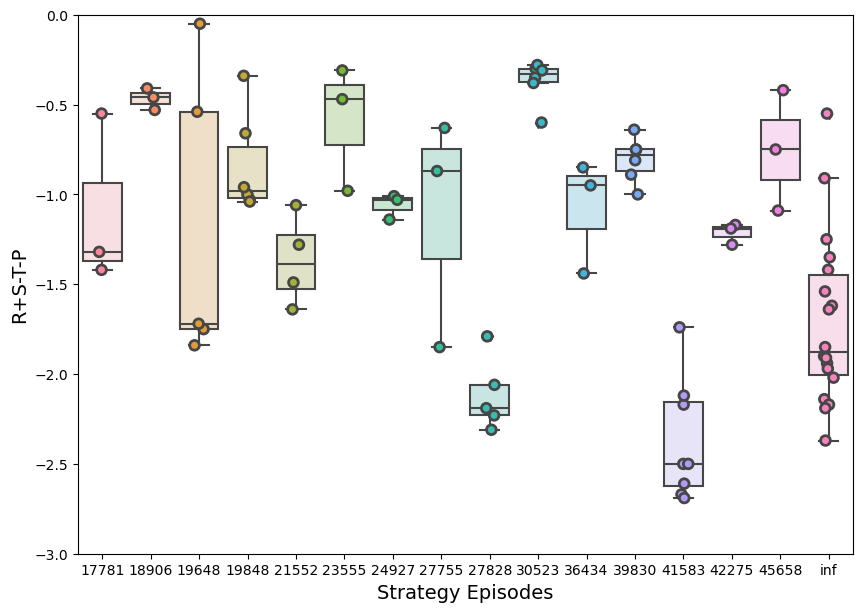

In [15]:
df_plot = df_result.copy()
df_plot = df_plot[df_plot['network_convergent_episode'].map(df_plot['network_convergent_episode'].value_counts()) > 2]

plt.figure(figsize=(10, 7))
ax = sns.boxplot(x='network_convergent_episode', y='R+S-T-P', data=df_plot)
sns.stripplot(x='network_convergent_episode', y='R+S-T-P', data=df_plot, alpha=1,
              size=7, linewidth=2)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
plt.xlabel('Strategy Episodes', fontsize=14)
plt.ylabel('R+S-T-P', fontsize=14)
plt.ylim(-3,0)
xticks_list = []
xticklabels_list = []
for i in ax.get_xticklabels():
    try:
        xticks_list.append(i.get_position()[0])
        xticklabels_list.append(int(float(i.get_text())))
    except: 
        xticklabels_list.append(i.get_text())
print(xticks_list, xticklabels_list)
ax.set_xticks(xticks_list)
ax.set_xticklabels(xticklabels_list)

<AxesSubplot:xlabel='R+S-T-P', ylabel='Count'>

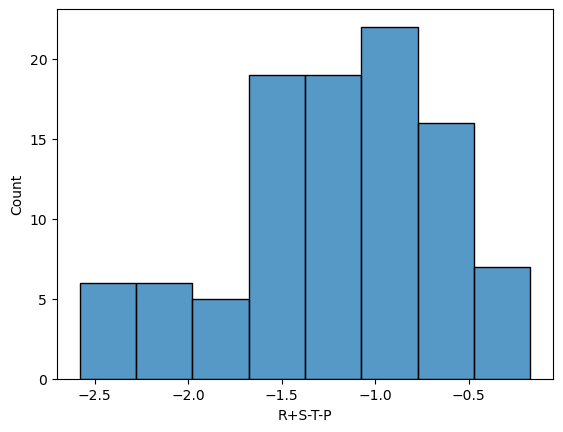

In [164]:
sns.histplot(data=df_result, x="R+S-T-P")

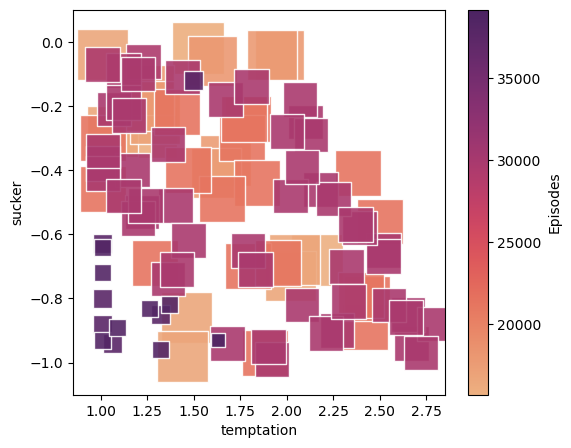

In [178]:
# df_result.loc[df_result['strategy_convergent_episode'] == np.inf, 'final_strategy'] = np.inf
df_result.loc[df_result['strategy_convergent_episode']==np.inf, 'strategy_convergent_episode'] = 52000
df_result.loc[df_result['network_convergent_episode']==np.inf, 'network_convergent_episode'] = 52000
plt.figure(figsize=(6, 5))
df_plot = df_result.sort_values(by=['strategy_convergent_episode'])
ax = sns.scatterplot(data=df_plot, y='sucker', x='temptation', 
                hue="strategy_convergent_episode", size="strategy_convergent_episode", sizes=(1400, 100), 
                linewidth=1, marker='s', alpha=0.9, palette='flare')
# plt.colorbar(label='strategy_convergent_episode')
lgnd = plt.legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.14)
# sns.lineplot(data=df_result, y='network_convergent_episode', x='R+S-T-P', label='Network')
# plt.vlines(0.05, -1, 10, 'r', '--')
# plt.vlines(0.95, -1, 10, 'r', '--')
# plt.hlines(0, -0.1, 1.1, 'b', '--')
# plt.ylim(-1,3)
# plt.xlim(-0.05,1.05)
# plt.text(0.07, 0.1, "y=0", c='blue')
# plt.text(0.07, 2.5, "x=0.05", c='red')
# plt.text(0.88, 2.5, "x=0.95", c='red')
# plt.ylabel('Episode number')
# plt.legend()
#change the marker size manually for both lines
for i in lgnd.legendHandles:
    i._sizes = [30]
plt.ylim(-1.1, 0.1)
plt.xlim(0.85,2.85)

    
norm = plt.Normalize(df_plot['strategy_convergent_episode'].min(), df_plot['strategy_convergent_episode'].max())
sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm, label='Episodes')
plt.show()

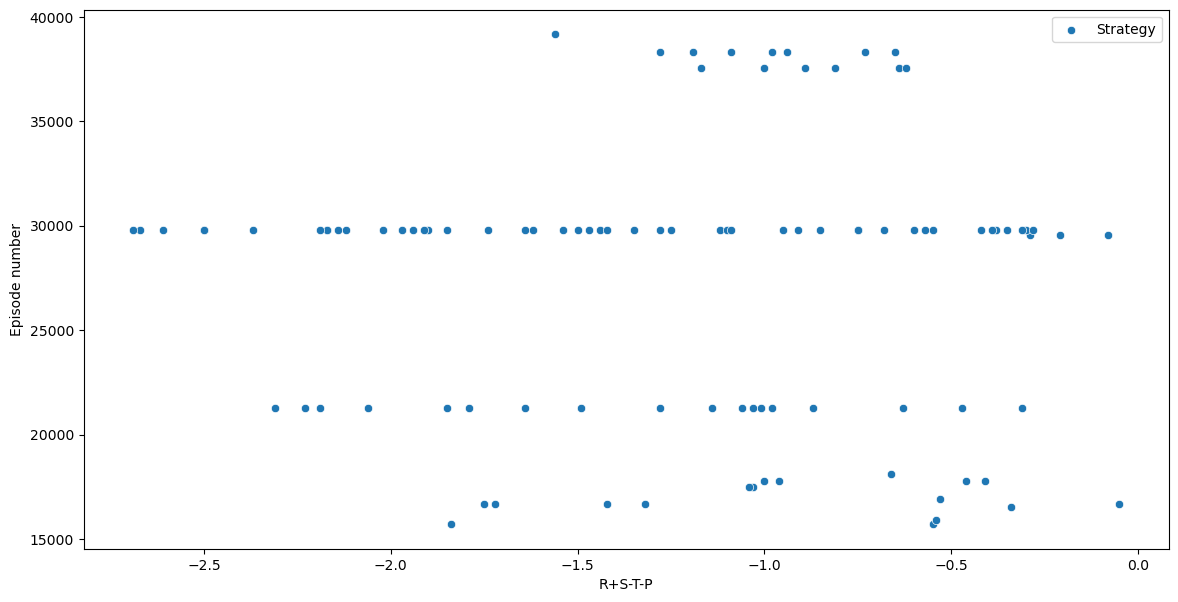

In [17]:
# df_result.loc[df_result['strategy_convergent_episode'] == np.inf, 'final_strategy'] = np.inf
df_result.loc[df_result['strategy_convergent_episode']==np.inf, 'strategy_convergent_episode'] = 52000
df_result.loc[df_result['network_convergent_episode']==np.inf, 'network_convergent_episode'] = 52000
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df_result, y='strategy_convergent_episode', x='R+S-T-P', label='Strategy')
# sns.lineplot(data=df_result, y='network_convergent_episode', x='R+S-T-P', label='Network')
# plt.vlines(0.05, -1, 10, 'r', '--')
# plt.vlines(0.95, -1, 10, 'r', '--')
# plt.hlines(0, -0.1, 1.1, 'b', '--')
# plt.ylim(-1,3)
# plt.xlim(-0.05,1.05)
# plt.text(0.07, 0.1, "y=0", c='blue')
# plt.text(0.07, 2.5, "x=0.05", c='red')
# plt.text(0.88, 2.5, "x=0.95", c='red')
plt.ylabel('Episode number')
plt.legend()

# Stag Hunt

In [4]:
reward, temptation, sucker, punishment = generate_payoff_matrix('SH', N=100)
df_result_sh = pd.DataFrame(columns=['strategy_convergent_episode', 'network_convergent_episode', 'temptation', 
                                  'reward', 'punishment', 'sucker', 'final_strategy', 'defection_ratio'])
for idx, val in tqdm(enumerate(reward)):
    config['h'] = 2
    config['n_episodes'] = 50000  # convergent threshold
    config['epsilon_decay'] = 0.995
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        agent, strategy_convergent_episode, network_convergent_episode, _ = TwoAgentSimulation.benchmark_episodic('LSTMQN', config_obj)
#     agent.show()
    df_result_sh.loc[len(df_result_sh.index)] = [strategy_convergent_episode, network_convergent_episode, 
                                           config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                           round(float(torch.sum(agent.own_memory[agent.play_times-100:agent.play_times])/100)),
                                           float(torch.sum(agent.own_memory)/agent.play_times)]

100it [2:01:39, 73.00s/it]


In [71]:
df_result_sh.loc[df_result_sh['strategy_convergent_episode'] >= 50000, 'strategy_convergent_episode'] = np.nan
df_result_sh.loc[df_result_sh['network_convergent_episode'] >= 50000, 'network_convergent_episode'] = np.nan
sum(df_result_sh['network_convergent_episode'].isnull())
sum(df_result_sh['strategy_convergent_episode'].isnull())

4

In [18]:
df_result_sh.loc[df_result_sh['strategy_convergent_episode'] >= 50000, 'strategy_convergent_episode'] = np.nan
df_result_sh.loc[df_result_sh['network_convergent_episode'] >= 50000, 'network_convergent_episode'] = np.nan
df_result_sh['R+S-T-P'] = df_result_sh['reward'] + df_result_sh['sucker'] - df_result_sh['temptation'] - df_result_sh['punishment']
df_result_sh.loc[df_result_sh['network_convergent_episode'].isnull()]

,strategy_convergent_episode,network_convergent_episode,temptation,reward,punishment,sucker,final_strategy,defection_ratio,R+S-T-P
3,47261.0,NaN,0.51,2.39,0.0,-0.49,0.0,0.392735,1.39
7,47261.0,NaN,0.75,3.46,0.0,-0.25,0.0,0.087706,2.46
12,47261.0,NaN,0.92,3.33,0.0,-0.08,0.0,0.081406,2.33
18,47261.0,NaN,0.88,1.73,0.0,-0.12,0.0,0.073929,0.73
27,47261.0,NaN,0.85,2.06,0.0,-0.15,0.0,0.096499,1.06
28,NaN,NaN,0.02,2.37,0.0,-0.98,1.0,0.529408,1.37
41,NaN,NaN,0.26,1.98,0.0,-0.74,0.0,0.319443,0.98
45,47261.0,NaN,0.05,2.65,0.0,-0.95,0.0,0.411616,1.65
52,47261.0,NaN,0.15,3.76,0.0,-0.85,0.0,0.190964,2.76
53,47261.0,NaN,0.49,3.58,0.0,-0.51,0.0,0.390083,2.58


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] [15710, 16404, 16682, 17485, 17781, 18091, 19848, 21256, 26548, 29532, 47261, 'inf']


[Text(0, 0, '15710'),
 Text(1, 0, '16404'),
 Text(2, 0, '16682'),
 Text(3, 0, '17485'),
 Text(4, 0, '17781'),
 Text(5, 0, '18091'),
 Text(6, 0, '19848'),
 Text(7, 0, '21256'),
 Text(8, 0, '26548'),
 Text(9, 0, '29532'),
 Text(10, 0, '47261'),
 Text(11, 0, 'inf')]

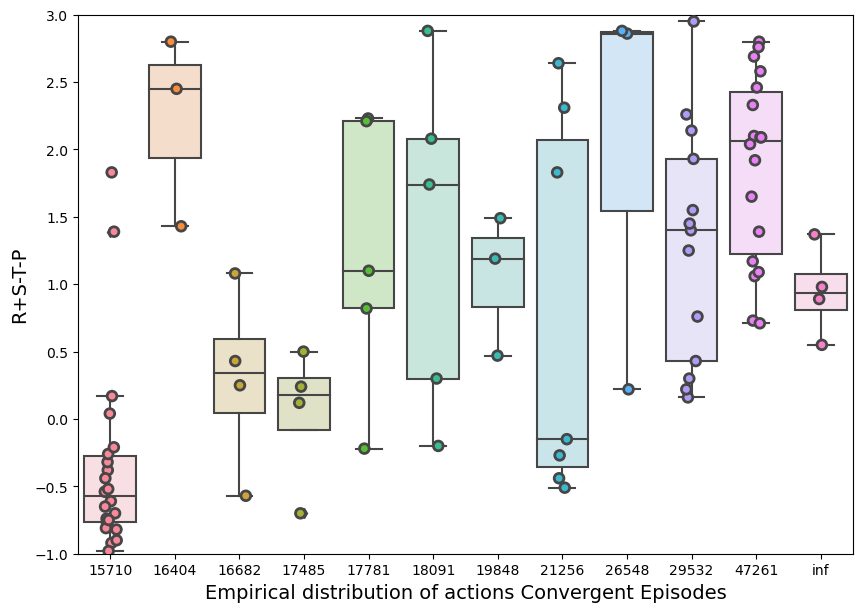

In [19]:
df_result_sh.loc[df_result_sh['strategy_convergent_episode'].isnull(), 'strategy_convergent_episode'] = np.inf
df_result_sh.loc[df_result_sh['network_convergent_episode'] >= 50000, 'network_convergent_episode'] = np.nan
df_result_sh.loc[df_result_sh['network_convergent_episode'].isnull(), 'network_convergent_episode'] = np.inf

df_plot = df_result_sh.copy()
df_plot = df_plot[df_plot['strategy_convergent_episode'].map(df_plot['strategy_convergent_episode'].value_counts()) > 2]
# df_plot = df_plot.astype({'strategy_convergent_episode':'int'})

plt.figure(figsize=(10, 7))
ax = sns.boxplot(x='strategy_convergent_episode', y='R+S-T-P', data=df_plot)
sns.stripplot(x='strategy_convergent_episode', y='R+S-T-P', data=df_plot, alpha=1,
              size=7,  linewidth=2)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
plt.xlabel('Empirical distribution of actions Convergent Episodes', fontsize=14)
plt.ylabel('R+S-T-P', fontsize=14)
plt.ylim(-1,3)

xticks_list = []
xticklabels_list = []
for i in ax.get_xticklabels():
    try:
        xticks_list.append(i.get_position()[0])
        xticklabels_list.append(int(float(i.get_text())))
    except: 
        xticklabels_list.append(i.get_text())
print(xticks_list, xticklabels_list)
ax.set_xticks(xticks_list)
ax.set_xticklabels(xticklabels_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [15898, 16905, 18579, 19040, 19848, 20275, 27098, 32049, 47474, 'inf']


[Text(0, 0, '15898'),
 Text(1, 0, '16905'),
 Text(2, 0, '18579'),
 Text(3, 0, '19040'),
 Text(4, 0, '19848'),
 Text(5, 0, '20275'),
 Text(6, 0, '27098'),
 Text(7, 0, '32049'),
 Text(8, 0, '47474'),
 Text(9, 0, 'inf')]

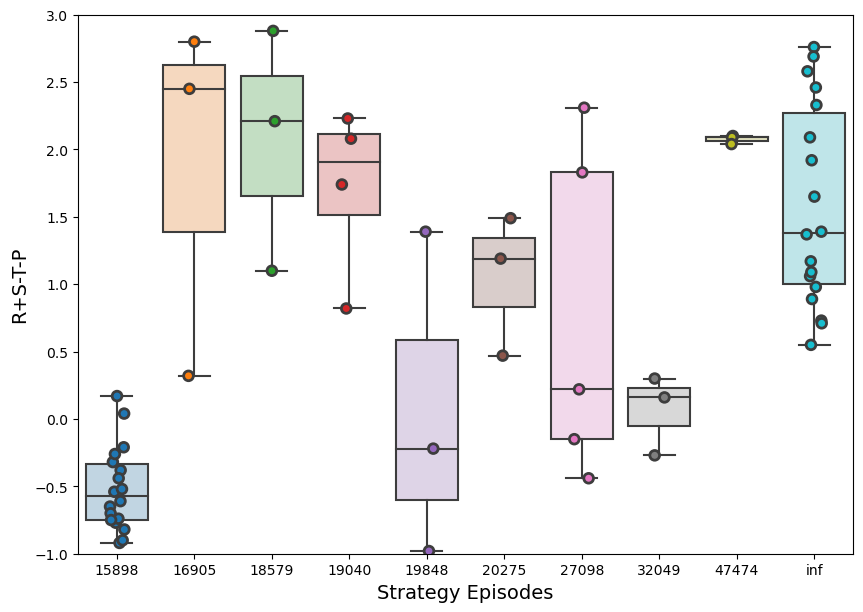

In [20]:
df_plot = df_result_sh.copy()
df_plot = df_plot[df_plot['network_convergent_episode'].map(df_plot['network_convergent_episode'].value_counts()) > 2]

plt.figure(figsize=(10, 7))
ax = sns.boxplot(x='network_convergent_episode', y='R+S-T-P', data=df_plot)
sns.stripplot(x='network_convergent_episode', y='R+S-T-P', data=df_plot, alpha=1,
              size=7,  linewidth=2)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
plt.xlabel('Strategy Episodes', fontsize=14)
plt.ylabel('R+S-T-P', fontsize=14)
plt.ylim(-1,3)
xticks_list = []
xticklabels_list = []
for i in ax.get_xticklabels():
    try:
        xticks_list.append(i.get_position()[0])
        xticklabels_list.append(int(float(i.get_text())))
    except: 
        xticklabels_list.append(i.get_text())
print(xticks_list, xticklabels_list)
ax.set_xticks(xticks_list)
ax.set_xticklabels(xticklabels_list)

In [91]:
df_sh_plot = df_result_sh.copy()
df_sh_plot.temptation = df_sh_plot.temptation/df_sh_plot.reward
df_sh_plot.sucker = df_sh_plot.sucker/df_sh_plot.reward
df_sh_plot['new_reward'] = 1.0

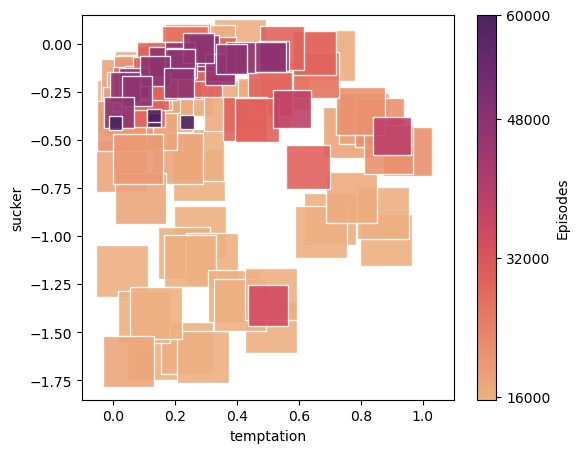

In [148]:
df_sh_plot.loc[df_sh_plot['strategy_convergent_episode']>=50000, 'strategy_convergent_episode'] = 60000
df_sh_plot.loc[df_sh_plot['strategy_convergent_episode'].isnull(), 'strategy_convergent_episode'] = 60000

plt.figure(figsize=(6, 5))
ax = sns.scatterplot(data=df_sh_plot.sort_values(by=['strategy_convergent_episode']), y='sucker', x='temptation', 
                hue="strategy_convergent_episode", size="strategy_convergent_episode", sizes=(1400, 100), 
                linewidth=1, marker='s', alpha=0.9, palette='flare')
lgnd = plt.legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.14, shadow=True,
                 labels=[16000,24000,'32000','40000','48000','Diverge'])
plt.xlim(-0.1,1.1)
plt.ylim(-1.85,0.15)

for i in lgnd.legendHandles:
    i._sizes = [30]
    
norm = plt.Normalize(df_sh_plot['strategy_convergent_episode'].min(), df_sh_plot['strategy_convergent_episode'].max())
sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm, label='Episodes', ticks=[16000, 32000, 48000, 60000])
plt.show()

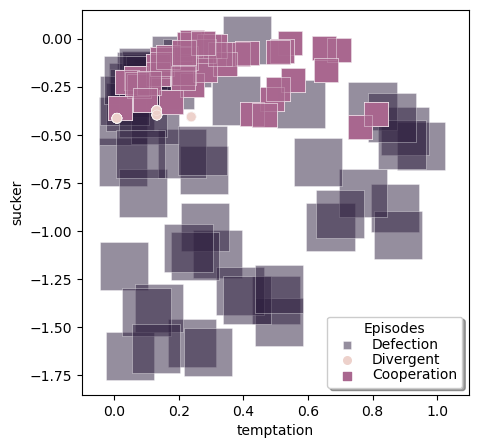

In [105]:
# df_sh_plot.loc[df_sh_plot['strategy_convergent_episode']>=50000, 'strategy_convergent_episode'] = 60000
df_sh_plot2 = df_sh_plot.copy()
df_sh_plot2.loc[df_sh_plot2['strategy_convergent_episode']>=50000, 'final_strategy'] = -1
df_sh_plot2 = pd.concat([df_sh_plot2,df_sh_plot2.loc[df_sh_plot2.final_strategy==-1]],ignore_index=True)
df_sh_plot2 = pd.concat([df_sh_plot2,df_sh_plot2.loc[df_sh_plot2.final_strategy==-1]],ignore_index=True)
df_sh_plot2 = pd.concat([df_sh_plot2,df_sh_plot2.loc[df_sh_plot2.final_strategy==-1]],ignore_index=True)
df_sh_plot2 = pd.concat([df_sh_plot2,df_sh_plot2.loc[df_sh_plot2.final_strategy==-1]],ignore_index=True)
df_sh_plot2 = pd.concat([df_sh_plot2,df_sh_plot2.loc[df_sh_plot2.final_strategy==0]],ignore_index=True)
df_sh_plot2 = pd.concat([df_sh_plot2,df_sh_plot2.loc[df_sh_plot2.final_strategy==0]],ignore_index=True)
df_sh_plot2 = pd.concat([df_sh_plot2,df_sh_plot2.loc[df_sh_plot2.final_strategy==0]],ignore_index=True)

plt.figure(figsize=(5, 5))
ax = sns.scatterplot(data=df_sh_plot2.sort_values(by=['final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="final_strategy", size="final_strategy", sizes=[50,300,1200], 
                linewidth=0.5, alpha=.5, style="final_strategy", markers=['o','s','s'])

# markerprops = dict(markeredgewidth=1.25, markeredgecolor='black', markersize=7, markerfacecolor='none')
# handles, labels = ax.get_legend_handles_labels()
# for h in handles:
#     h.set(**markerprops)
    
lgnd = plt.legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection', 'Divergent', 'Cooperation'], loc='lower right', shadow=True)
plt.xlim(-0.1,1.1)
plt.ylim(-1.85,0.15)

#change the marker size manually for both lines
for i in lgnd.legendHandles:
    i._sizes = [30]

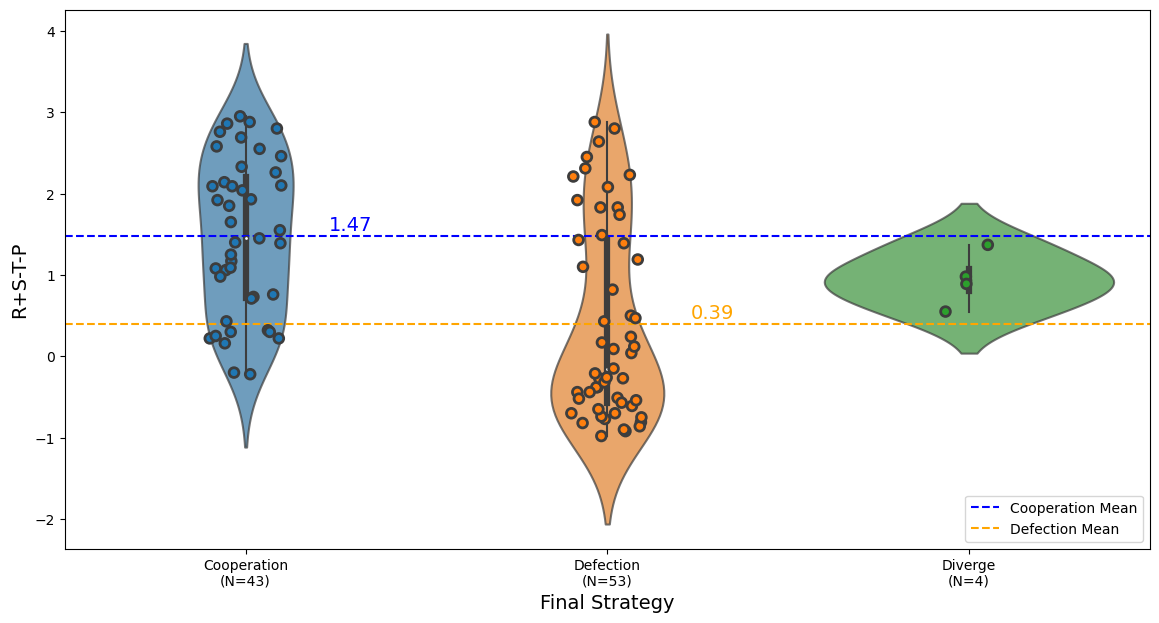

In [24]:
df_result_sh.loc[df_result_sh['strategy_convergent_episode'].isnull(), 'strategy_convergent_episode'] = np.inf
# df_plot = df_result_sh.loc[df_result_sh['strategy_convergent_episode'] != np.inf]
df_plot = df_result_sh.copy()
df_plot.loc[df_plot['strategy_convergent_episode'] == np.inf, 'final_strategy'] = np.inf

plt.figure(figsize=(14, 7))
ax = sns.violinplot(x = 'final_strategy', y = 'R+S-T-P', data = df_plot)
for violin, alpha in zip(ax.collections[::2], [0.7,0.7,0.7]):
    violin.set_alpha(alpha)
# for patch in ax.patches:
#     r, g, b, a = patch.get_facecolor()
#     patch.set_facecolor((r, g, b, .3))
    
sns.stripplot(x = 'final_strategy', y = 'R+S-T-P', data = df_plot, marker='o',
              size=7, linewidth=2)
    
# plt.hlines(np.mean(df_plot['R+S-T-P']), -0.5, 3, 'red', '--', label='Total Mean')
plt.hlines(np.mean(df_plot.loc[df_plot['final_strategy']==0, 'R+S-T-P']), -0.5, 3, 'blue', '--', label='Cooperation Mean')
plt.hlines(np.mean(df_plot.loc[df_plot['final_strategy']==1, 'R+S-T-P']), -0.5, 3, 'orange', '--', label='Defection Mean')
# plt.text(2.33, np.mean(df_plot['R+S-T-P'])+0.07, round(np.mean(df_plot['R+S-T-P']),2), c='red', fontsize=14)
plt.text(0.23, np.mean(df_plot.loc[df_plot['final_strategy']==0, 'R+S-T-P'])+0.07, round(np.mean(df_plot.loc[df_plot['final_strategy']==0, 'R+S-T-P']),2), c='blue', fontsize=14)
plt.text(1.23, np.mean(df_plot.loc[df_plot['final_strategy']==1, 'R+S-T-P'])+0.07, round(np.mean(df_plot.loc[df_plot['final_strategy']==1, 'R+S-T-P']),2), c='orange', fontsize=14)
plt.xlim(-0.5,2.5)
# plt.set_xticklabels()
ax.set_xticks([0, 1, 2])
ax.set_xticklabels([f"Cooperation\n(N={sum(df_plot['final_strategy']==0)})", f"Defection\n(N={sum(df_plot['final_strategy']==1)})", f"Diverge\n(N={sum(df_plot['final_strategy']==np.inf)})"])
plt.xlabel('Final Strategy', fontsize=14)
plt.ylabel('R+S-T-P', fontsize=14)
plt.legend(loc='lower right')


In [48]:
# reward, temptation, sucker, punishment = generate_payoff_matrix('SH', N=100)
# df_result_sh_2 = pd.DataFrame(columns=['strategy_convergent_episode', 'network_convergent_episode', 'temptation', 
#                                   'reward', 'punishment', 'sucker', 'final_strategy', 'defection_ratio'])
# for idx, val in tqdm(enumerate(reward)):
#     config['h'] = 10
#     config['n_episodes'] = 50000  # convergent threshold
#     config['epsilon_decay'] = 0.999
#     config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
#     config_obj = Config(config)
#     with HiddenPrints():
#         agent, strategy_convergent_episode, network_convergent_episode = twoSimulateEpisodicBenchmark('LSTMQN', config_obj)
# #     agent.show()
#     df_result_sh_2.loc[len(df_result_sh_2.index)] = [strategy_convergent_episode, network_convergent_episode, 
#                                            config['temptation'], config['reward'], config['punishment'], config['sucker'], 
#                                            round(float(torch.sum(agent.own_memory[agent.play_times-100:agent.play_times])/100)),
#                                            float(torch.sum(agent.own_memory)/agent.play_times)]

100it [3:24:19, 122.60s/it]


In [49]:
# df_result_sh_2.loc[df_result_sh_2['strategy_convergent_episode'] >= 50000, 'strategy_convergent_episode'] = np.nan
# df_result_sh_2.loc[df_result_sh_2['network_convergent_episode'] >= 50000, 'network_convergent_episode'] = np.nan
# df_result_sh_2['R+S-T-P'] = df_result_sh_2['reward'] + df_result_sh_2['sucker'] - df_result_sh_2['temptation'] - df_result_sh_2['punishment']
# df_result_sh_2.loc[df_result_sh_2['network_convergent_episode'].isnull()]

,strategy_convergent_episode,network_convergent_episode,temptation,reward,punishment,sucker,final_strategy,defection_ratio,R+S-T-P
0,NaN,NaN,0.13,1.60,0.0,-0.87,0.0,0.486482,0.60
1,NaN,NaN,0.97,2.96,0.0,-0.03,0.0,0.271772,1.96
2,NaN,NaN,0.19,1.00,0.0,-1.41,1.0,0.743321,-0.60
3,NaN,NaN,0.45,1.00,0.0,-0.66,1.0,0.671086,-0.11
4,NaN,NaN,0.49,2.90,0.0,-0.51,0.0,0.394130,1.90
5,NaN,NaN,0.81,1.32,0.0,-0.19,1.0,0.496431,0.32
6,NaN,NaN,0.11,3.43,0.0,-0.89,0.0,0.447962,2.43
7,NaN,NaN,0.43,1.63,0.0,-0.57,0.0,0.496670,0.63
8,NaN,NaN,0.63,2.77,0.0,-0.37,0.0,0.352022,1.77
9,NaN,NaN,0.22,1.41,0.0,-0.78,1.0,0.552735,0.41


In [52]:
# reward, temptation, sucker, punishment = generate_payoff_matrix('SH', N=100)
# df_result_sh_3 = pd.DataFrame(columns=['strategy_convergent_episode', 'network_convergent_episode', 'temptation', 
#                                   'reward', 'punishment', 'sucker', 'final_strategy', 'defection_ratio'])
# for idx, val in tqdm(enumerate(reward)):
#     config['h'] = 10
#     config['n_episodes'] = 50000  # convergent threshold
#     config['epsilon_decay'] = 0.995
#     config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
#     config_obj = Config(config)
#     with HiddenPrints():
#         agent, strategy_convergent_episode, network_convergent_episode = twoSimulateEpisodicBenchmark('LSTMQN', config_obj)
# #     agent.show()
#     df_result_sh_3.loc[len(df_result_sh_3.index)] = [strategy_convergent_episode, network_convergent_episode, 
#                                            config['temptation'], config['reward'], config['punishment'], config['sucker'], 
#                                            round(float(torch.sum(agent.own_memory[agent.play_times-100:agent.play_times])/100)),
#                                            float(torch.sum(agent.own_memory)/agent.play_times)]

100it [1:58:42, 71.23s/it] 


In [54]:
# df_result_sh_3.loc[df_result_sh_3['strategy_convergent_episode'] >= 50000, 'strategy_convergent_episode'] = np.nan
# df_result_sh_3.loc[df_result_sh_3['network_convergent_episode'] >= 50000, 'network_convergent_episode'] = np.nan
# df_result_sh_3['R+S-T-P'] = df_result_sh_3['reward'] + df_result_sh_3['sucker'] - df_result_sh_3['temptation'] - df_result_sh_3['punishment']
# # df_result_sh_3.loc[df_result_sh_2['network_convergent_episode'].isnull()]
# df_result_sh_3

,strategy_convergent_episode,network_convergent_episode,temptation,reward,punishment,sucker,final_strategy,defection_ratio,R+S-T-P
0,15898.0,16324.0,0.99,1.20,0.0,-0.01,1.0,0.767520,0.20
1,17781.0,18579.0,0.16,1.51,0.0,-0.84,1.0,0.690726,0.51
2,NaN,NaN,0.43,3.17,0.0,-0.57,0.0,0.316532,2.17
3,15898.0,19848.0,0.76,1.00,0.0,-1.01,1.0,0.887495,-0.77
4,27354.0,29067.0,0.95,1.85,0.0,-0.05,1.0,0.841160,0.85
5,NaN,NaN,0.88,1.28,0.0,-0.12,0.0,0.223941,0.28
6,17642.0,20119.0,0.26,3.37,0.0,-0.74,1.0,0.803171,2.37
7,NaN,NaN,0.09,2.78,0.0,-0.91,0.0,0.285310,1.78
8,15898.0,20404.0,0.29,1.00,0.0,-1.28,1.0,0.866497,-0.57
9,17781.0,20119.0,0.44,3.25,0.0,-0.56,1.0,0.553308,2.25


h=5

In [5]:
reward, temptation, sucker, punishment = generate_payoff_matrix('SH', N=100)
df_result_sh_4 = pd.DataFrame(columns=['strategy_convergent_episode', 'network_convergent_episode', 'temptation', 
                                  'reward', 'punishment', 'sucker', 'final_strategy', 'defection_ratio'])
for idx, val in tqdm(enumerate(reward)):
    config['h'] = 5
    config['n_episodes'] = 50000  # convergent threshold
    config['epsilon_decay'] = 0.995
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        agent, strategy_convergent_episode, network_convergent_episode, _ = TwoAgentSimulation.benchmark_episodic('LSTMQN', config_obj)
#     agent.show()
    df_result_sh_4.loc[len(df_result_sh_4.index)] = [strategy_convergent_episode, network_convergent_episode, 
                                           config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                           round(float(torch.sum(agent.own_memory[agent.play_times-100:agent.play_times])/100)),
                                           float(torch.sum(agent.own_memory)/agent.play_times)]

100it [1:55:50, 69.51s/it]


In [32]:
df_result_sh_4.loc[df_result_sh_4['strategy_convergent_episode'] >= 50000, 'strategy_convergent_episode'] = np.nan
df_result_sh_4.loc[df_result_sh_4['network_convergent_episode'] >= 50000, 'network_convergent_episode'] = np.nan
df_result_sh_4['R+S-T-P'] = df_result_sh_4['reward'] + df_result_sh_4['sucker'] - df_result_sh_4['temptation'] - df_result_sh_4['punishment']
# df_result_sh_3.loc[df_result_sh_2['network_convergent_episode'].isnull()]
df_result_sh_4

,strategy_convergent_episode,network_convergent_episode,temptation,reward,punishment,sucker,final_strategy,defection_ratio,R+S-T-P
0,15898.0,16324.0,0.04,1.50,0.0,-0.96,1.0,0.801274,0.50
1,26043.0,29532.0,0.63,3.80,0.0,-0.37,0.0,0.176249,2.80
2,17642.0,20119.0,0.32,2.93,0.0,-0.68,1.0,0.762364,1.93
3,18091.0,19040.0,0.51,2.39,0.0,-0.49,1.0,0.528887,1.39
4,16682.0,20992.0,0.90,1.00,0.0,-0.48,1.0,0.845989,-0.38
5,15898.0,17781.0,0.25,1.00,0.0,-1.13,1.0,0.806029,-0.38
6,15898.0,21720.0,0.41,1.00,0.0,-1.36,1.0,0.885681,-0.77
7,32749.0,40468.0,0.75,3.46,0.0,-0.25,0.0,0.231343,2.46
8,18091.0,19253.0,0.23,2.40,0.0,-0.77,1.0,0.787202,1.40
9,32749.0,40468.0,0.09,2.83,0.0,-0.91,0.0,0.358950,1.83


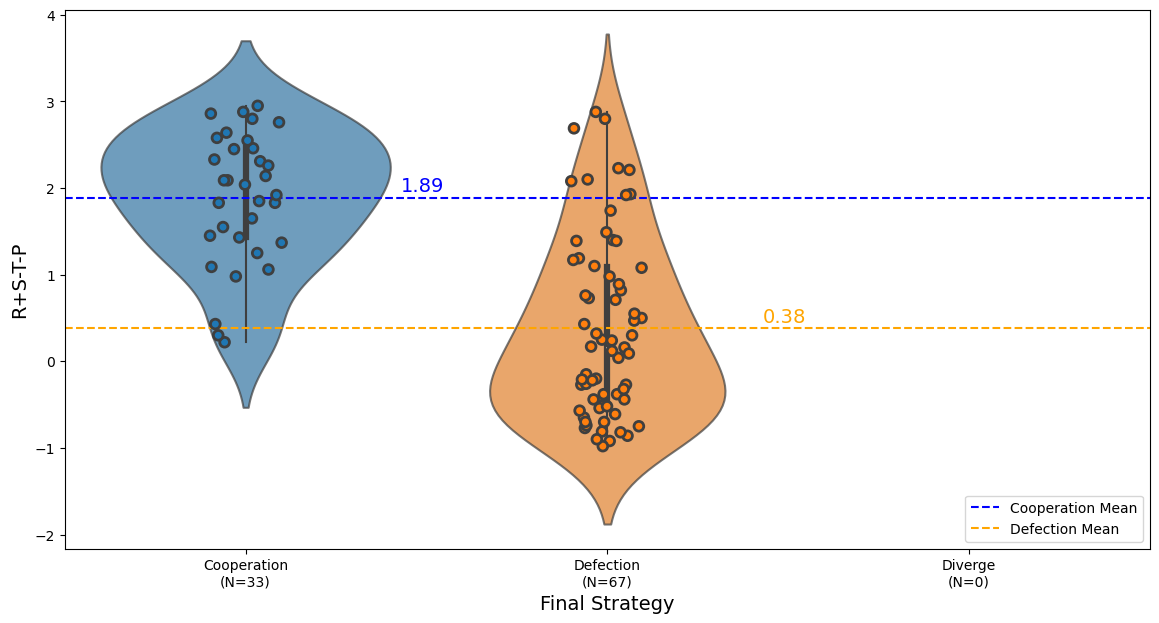

In [33]:
df_result_sh_4.loc[df_result_sh_4['strategy_convergent_episode'].isnull(), 'strategy_convergent_episode'] = np.inf
# df_plot = df_result_sh.loc[df_result_sh['strategy_convergent_episode'] != np.inf]
df_plot = df_result_sh_4.copy()
df_plot.loc[df_plot['strategy_convergent_episode'] == np.inf, 'final_strategy'] = np.inf

plt.figure(figsize=(14, 7))
ax = sns.violinplot(x = 'final_strategy', y = 'R+S-T-P', data = df_plot)
for violin, alpha in zip(ax.collections[::2], [0.7,0.7,0.7]):
    violin.set_alpha(alpha)
# for patch in ax.patches:
#     r, g, b, a = patch.get_facecolor()
#     patch.set_facecolor((r, g, b, .3))
    
sns.stripplot(x = 'final_strategy', y = 'R+S-T-P', data = df_plot, marker='o',
              size=7, linewidth=2)

    
# plt.hlines(np.mean(df_plot['R+S-T-P']), -0.5, 3, 'red', '--', label='Total Mean')
plt.hlines(np.mean(df_plot.loc[df_plot['final_strategy']==0, 'R+S-T-P']), -0.5, 3, 'blue', '--', label='Cooperation Mean')
plt.hlines(np.mean(df_plot.loc[df_plot['final_strategy']==1, 'R+S-T-P']), -0.5, 3, 'orange', '--', label='Defection Mean')
# plt.text(2.33, np.mean(df_plot['R+S-T-P'])+0.07, round(np.mean(df_plot['R+S-T-P']),2), c='red', fontsize=14)
plt.text(0.43, np.mean(df_plot.loc[df_plot['final_strategy']==0, 'R+S-T-P'])+0.07, round(np.mean(df_plot.loc[df_plot['final_strategy']==0, 'R+S-T-P']),2), c='blue', fontsize=14)
plt.text(1.43, np.mean(df_plot.loc[df_plot['final_strategy']==1, 'R+S-T-P'])+0.07, round(np.mean(df_plot.loc[df_plot['final_strategy']==1, 'R+S-T-P']),2), c='orange', fontsize=14)
plt.xlim(-0.5,2.5)
# plt.set_xticklabels()
ax.set_xticks([0, 1, 2])
ax.set_xticklabels([f"Cooperation\n(N={sum(df_plot['final_strategy']==0)})", f"Defection\n(N={sum(df_plot['final_strategy']==1)})", f"Diverge\n(N={sum(df_plot['final_strategy']==np.inf)})"])
plt.xlabel('Final Strategy', fontsize=14)
plt.ylabel('R+S-T-P', fontsize=14)
plt.legend(loc='lower right')


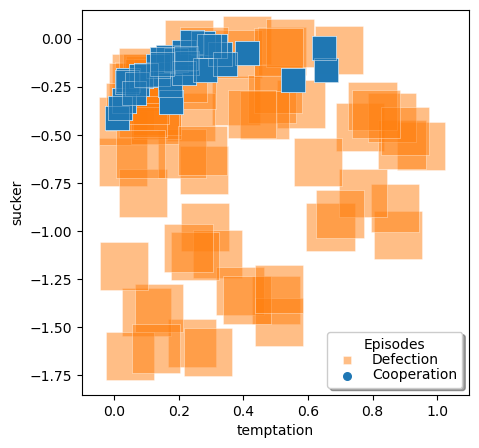

In [152]:
df_sh_plot = df_result_sh_4.copy()
df_sh_plot.temptation = df_sh_plot.temptation/df_sh_plot.reward
df_sh_plot.sucker = df_sh_plot.sucker/df_sh_plot.reward
df_sh_plot['new_reward'] = 1.0

df_sh_plot2 = df_sh_plot.copy()
df_sh_plot2.loc[df_sh_plot2['strategy_convergent_episode']>=50000, 'final_strategy'] = -1
df_sh_plot2 = pd.concat([df_sh_plot2,df_sh_plot2.loc[df_sh_plot2.final_strategy==-1]],ignore_index=True)
df_sh_plot2 = pd.concat([df_sh_plot2,df_sh_plot2.loc[df_sh_plot2.final_strategy==-1]],ignore_index=True)
df_sh_plot2 = pd.concat([df_sh_plot2,df_sh_plot2.loc[df_sh_plot2.final_strategy==-1]],ignore_index=True)
df_sh_plot2 = pd.concat([df_sh_plot2,df_sh_plot2.loc[df_sh_plot2.final_strategy==-1]],ignore_index=True)
df_sh_plot2 = pd.concat([df_sh_plot2,df_sh_plot2.loc[df_sh_plot2.final_strategy==0]],ignore_index=True)
df_sh_plot2 = pd.concat([df_sh_plot2,df_sh_plot2.loc[df_sh_plot2.final_strategy==0]],ignore_index=True)
df_sh_plot2 = pd.concat([df_sh_plot2,df_sh_plot2.loc[df_sh_plot2.final_strategy==0]],ignore_index=True)

plt.figure(figsize=(5, 5))
ax = sns.scatterplot(data=df_sh_plot2.sort_values(by=['final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="final_strategy", size="final_strategy", sizes=[300,1200], 
                linewidth=0.5, alpha=.5, marker='s')

# markerprops = dict(markeredgewidth=1.25, markeredgecolor='black', markersize=7, markerfacecolor='none')
# handles, labels = ax.get_legend_handles_labels()
# for h in handles:
#     h.set(**markerprops)
    
lgnd = plt.legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection', 'Cooperation'], loc='lower right', shadow=True)
plt.xlim(-0.1,1.1)
plt.ylim(-1.85,0.15)

#change the marker size manually for both lines
for i in lgnd.legendHandles:
    i._sizes = [30]


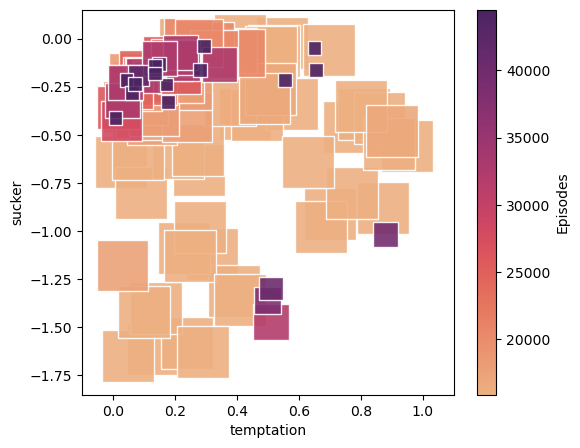

In [161]:
df_sh_plot.loc[df_sh_plot['strategy_convergent_episode']>=50000, 'strategy_convergent_episode'] = 60000
plt.figure(figsize=(6, 5))
ax = sns.scatterplot(data=df_sh_plot.sort_values(by=['strategy_convergent_episode']), y='sucker', x='temptation', 
                hue="strategy_convergent_episode", size="strategy_convergent_episode", sizes=(1400, 100), 
                linewidth=1, marker='s', alpha=0.9, palette='flare')
lgnd = plt.legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.14, shadow=True)
plt.xlim(-0.1,1.1)
plt.ylim(-1.85,0.15)

for i in lgnd.legendHandles:
    i._sizes = [30]
    
    
norm = plt.Normalize(df_sh_plot['strategy_convergent_episode'].min(), df_sh_plot['strategy_convergent_episode'].max())
sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm, label='Episodes', ticks=[20000,25000,30000,35000,40000,50000])
plt.show()

In [160]:
# sum(df_result_sh_4['network_convergent_episode'].isnull())
sum(df_result_sh_4['strategy_convergent_episode'].isnull())

0

# Snowdrift

In [6]:
reward, temptation, sucker, punishment = generate_payoff_matrix('SD', N=100)
df_result_sd = pd.DataFrame(columns=['strategy_convergent_episode', 'network_convergent_episode', 'temptation', 
                                  'reward', 'punishment', 'sucker', 'final_strategy', 'defection_ratio'])
for idx, val in tqdm(enumerate(reward)):
    config['h'] = 2
    config['n_episodes'] = 50000  # convergent threshold
    config['epsilon_decay'] = 0.995
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        agent, strategy_convergent_episode, network_convergent_episode, _ = TwoAgentSimulation.benchmark_episodic('LSTMQN', config_obj)
#     agent.show()
    df_result_sd.loc[len(df_result_sd.index)] = [strategy_convergent_episode, network_convergent_episode, 
                                           config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                           round(float(torch.sum(agent.own_memory[agent.play_times-100:agent.play_times])/100)),
                                           float(torch.sum(agent.own_memory)/agent.play_times)]

100it [1:34:46, 56.87s/it]


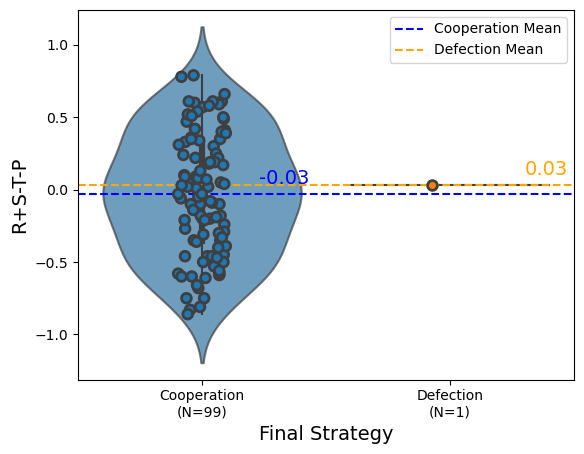

In [43]:
df_result_sd['R+S-T-P'] = df_result_sd['reward'] + df_result_sd['sucker'] - df_result_sd['temptation'] - df_result_sd['punishment']

df_result_sd.loc[df_result_sd['strategy_convergent_episode'].isnull(), 'strategy_convergent_episode'] = np.inf
# df_plot = df_result_sh.loc[df_result_sh['strategy_convergent_episode'] != np.inf]
df_plot = df_result_sd.copy()
df_plot.loc[df_plot['strategy_convergent_episode'] == np.inf, 'final_strategy'] = np.inf

ax = sns.violinplot(x = 'final_strategy', y = 'R+S-T-P', data = df_plot)
for violin, alpha in zip(ax.collections[::2], [0.7,0.7,0.7]):
    violin.set_alpha(alpha)
# for patch in ax.patches:
#     r, g, b, a = patch.get_facecolor()
#     patch.set_facecolor((r, g, b, .3))
    
sns.stripplot(x = 'final_strategy', y = 'R+S-T-P', data = df_plot, marker='o',
              size=7, linewidth=2)

    
# plt.hlines(np.mean(df_plot['R+S-T-P']), -0.5, 3, 'red', '--', label='Total Mean')
plt.hlines(np.mean(df_plot.loc[df_plot['final_strategy']==0, 'R+S-T-P']), -0.5, 3, 'blue', '--', label='Cooperation Mean')
plt.hlines(np.mean(df_plot.loc[df_plot['final_strategy']==1, 'R+S-T-P']), -0.5, 3, 'orange', '--', label='Defection Mean')
# plt.text(2.33, np.mean(df_plot['R+S-T-P'])+0.07, round(np.mean(df_plot['R+S-T-P']),2), c='red', fontsize=14)
plt.text(0.23, np.mean(df_plot.loc[df_plot['final_strategy']==0, 'R+S-T-P'])+0.07, round(np.mean(df_plot.loc[df_plot['final_strategy']==0, 'R+S-T-P']),2), c='blue', fontsize=14)
plt.text(1.3, np.mean(df_plot.loc[df_plot['final_strategy']==1, 'R+S-T-P'])+0.07, round(np.mean(df_plot.loc[df_plot['final_strategy']==1, 'R+S-T-P']),2), c='orange', fontsize=14)
plt.xlim(-0.5,2.5)
# plt.set_xticklabels()
ax.set_xticks([0, 1, 2])
ax.set_xticklabels([f"Cooperation\n(N={sum(df_plot['final_strategy']==0)})", f"Defection\n(N={sum(df_plot['final_strategy']==1)})", f"Diverge\n(N={sum(df_plot['final_strategy']==np.inf)})"])
plt.xlabel('Final Strategy', fontsize=14)
plt.ylabel('R+S-T-P', fontsize=14)
plt.legend(loc='lower right')
plt.xlim(-0.5,1.5)
plt.legend()

In [68]:
df_result_sd.loc[df_result_sh['strategy_convergent_episode'] >= 50000, 'strategy_convergent_episode'] = np.nan
df_result_sd.loc[df_result_sh['network_convergent_episode'] >= 50000, 'network_convergent_episode'] = np.nan
sum(df_result_sd['network_convergent_episode'].isnull())
# sum(df_result_sd['strategy_convergent_episode'].isnull())

1

# Harmony

In [219]:
reward, temptation, sucker, punishment = generate_payoff_matrix('Ha', N=100)
df_result_Ha = pd.DataFrame(columns=['strategy_convergent_episode', 'network_convergent_episode', 'temptation', 
                                  'reward', 'punishment', 'sucker', 'final_strategy', 'defection_ratio'])
for idx, val in tqdm(enumerate(reward)):
    config['h'] = 2
    config['n_episodes'] = 50000  # convergent threshold
    config['epsilon_decay'] = 0.995
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        agent, strategy_convergent_episode, network_convergent_episode, _ = TwoAgentSimulation.benchmark_episodic('LSTMQN', config_obj)
#     agent.show()
    df_result_Ha.loc[len(df_result_Ha.index)] = [strategy_convergent_episode, network_convergent_episode, 
                                           config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                           round(float(torch.sum(agent.own_memory[agent.play_times-100:agent.play_times])/100)),
                                           float(torch.sum(agent.own_memory)/agent.play_times)]

100it [1:30:41, 54.41s/it]


# All result

In [319]:
df_result['game'] = 'PD'
df_result_sh['game'] = 'SH'
df_result_sd['game'] = 'SD'
df_result_Ha['game'] = 'Ha'

df_all = pd.concat([df_result, df_result_sh],ignore_index=True)
df_all = pd.concat([df_all, df_result_sd],ignore_index=True)
df_all = pd.concat([df_all, df_result_Ha],ignore_index=True)

df_all.loc[df_all['strategy_convergent_episode']>=50000, 'strategy_convergent_episode'] = 55000
df_all.loc[df_all['strategy_convergent_episode'].isnull(), 'strategy_convergent_episode'] = 55000
df_all.loc[df_all['network_convergent_episode'].isnull(), 'network_convergent_episode'] = 55000
df_all.loc[df_all['strategy_convergent_episode']>=50000, 'final_strategy'] = -1

df_all.to_csv('h=2.csv',index=False)

In [2]:
df_all = pd.read_csv('h=2.csv') 


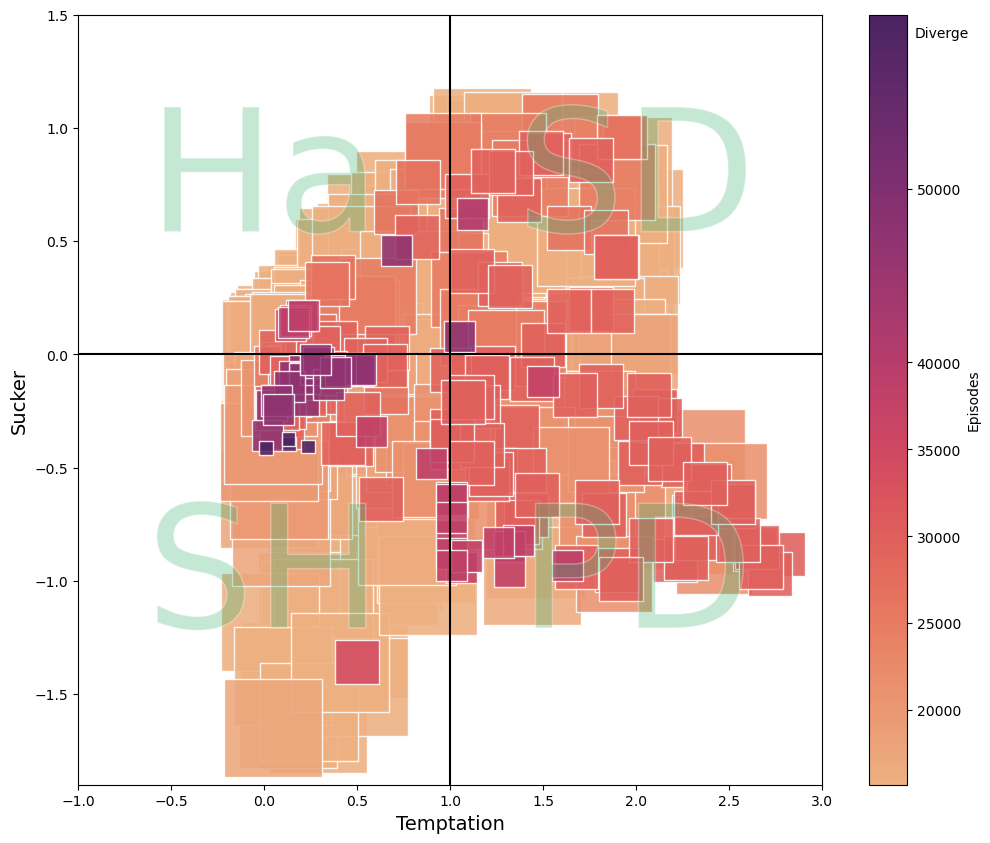

In [8]:
df_all_plot = df_all.copy()
df_all_plot.temptation = df_all_plot.temptation/df_all_plot.reward
df_all_plot.sucker = df_all_plot.sucker/df_all_plot.reward
df_all_plot['new_reward'] = 1.0

df_all_plot.loc[df_all_plot['strategy_convergent_episode']>=50000, 'strategy_convergent_episode'] = 60000

df_all_plot['size'] = 5000
df_all_plot.loc[df_all_plot['strategy_convergent_episode']>=20000, 'size'] = 3000
df_all_plot.loc[df_all_plot['strategy_convergent_episode']>=25000, 'size'] = 1000
df_all_plot.loc[df_all_plot['strategy_convergent_episode']>=35000, 'size'] = 500
df_all_plot.loc[df_all_plot['strategy_convergent_episode']>=50000, 'size'] = 100


plt.figure(figsize=(12, 10))
ax = sns.scatterplot(data=df_all_plot.sort_values(by=['strategy_convergent_episode'],ascending=True), y='sucker', x='temptation', 
                hue="strategy_convergent_episode", size="size", sizes=(100, 5000), 
                linewidth=1, marker='s', alpha=0.88, palette='flare')
lgnd = plt.legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.14, shadow=True)

for i in lgnd.legendHandles:
    i._sizes = [30]
    
plt.vlines(1, -2, 10, 'black')
plt.hlines(0, -10, 10, 'black')

t = ax.text(2, -1, "PD", alpha = .1, animated = True,
       fontsize = 123,      # Size
       ha = "center", # Horizontal alignment
       va = "center")
t.set_path_effects([
#     path_effects.PathPatchEffect(
#         offset=(4, -4), hatch='', facecolor='#708090', alpha=.3, edgecolor='white' ),
    path_effects.PathPatchEffect(
        edgecolor='white', linewidth=1.1, facecolor='#3CB371', alpha=.3)])

t = ax.text(0, -1, "SH", alpha = .5, animated = True,
       fontsize = 123, fontstyle = "normal", color = "grey", ha = "center",  va = "center")
t.set_path_effects([
#     path_effects.PathPatchEffect(
#         offset=(4, -4), hatch='', facecolor='#708090', alpha=.3, edgecolor='white' ),
    path_effects.PathPatchEffect(
        edgecolor='white', linewidth=1.1, facecolor='#3CB371', alpha=.3)])

t = ax.text(0, 0.75, "Ha", alpha = .5, animated = True,
       fontsize = 123, fontstyle = "normal", color = "grey", ha = "center",  va = "center")
t.set_path_effects([
#     path_effects.PathPatchEffect(
#         offset=(4, -4), hatch='', facecolor='#708090', alpha=.3, edgecolor='white' ),
    path_effects.PathPatchEffect(
        edgecolor='white', linewidth=1.1, facecolor='#3CB371', alpha=.3)])

t = ax.text(2, 0.75, "SD",  alpha = .3, animated = True,
       fontsize = 123, color = "grey", ha = "center",  va = "center")
t.set_path_effects([
#     path_effects.PathPatchEffect(
#         offset=(4, -4), hatch='', facecolor='#708090', alpha=.3, edgecolor='white' ),
    path_effects.PathPatchEffect(
        edgecolor='white', linewidth=1.1, facecolor='#3CB371', alpha=.3)])

ax.text(3.5, 1.4, "Diverge", color = "black")
plt.xlim(-1,3)
plt.ylim(-1.9,1.5)
    
norm = plt.Normalize(df_all_plot['strategy_convergent_episode'].min(), df_all_plot['strategy_convergent_episode'].max())
sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm, label='Episodes', ticks=[15000,20000,25000,30000,35000,40000,50000])

plt.xlabel('Temptation', fontsize=14)
plt.ylabel('Sucker', fontsize=14)
plt.show()

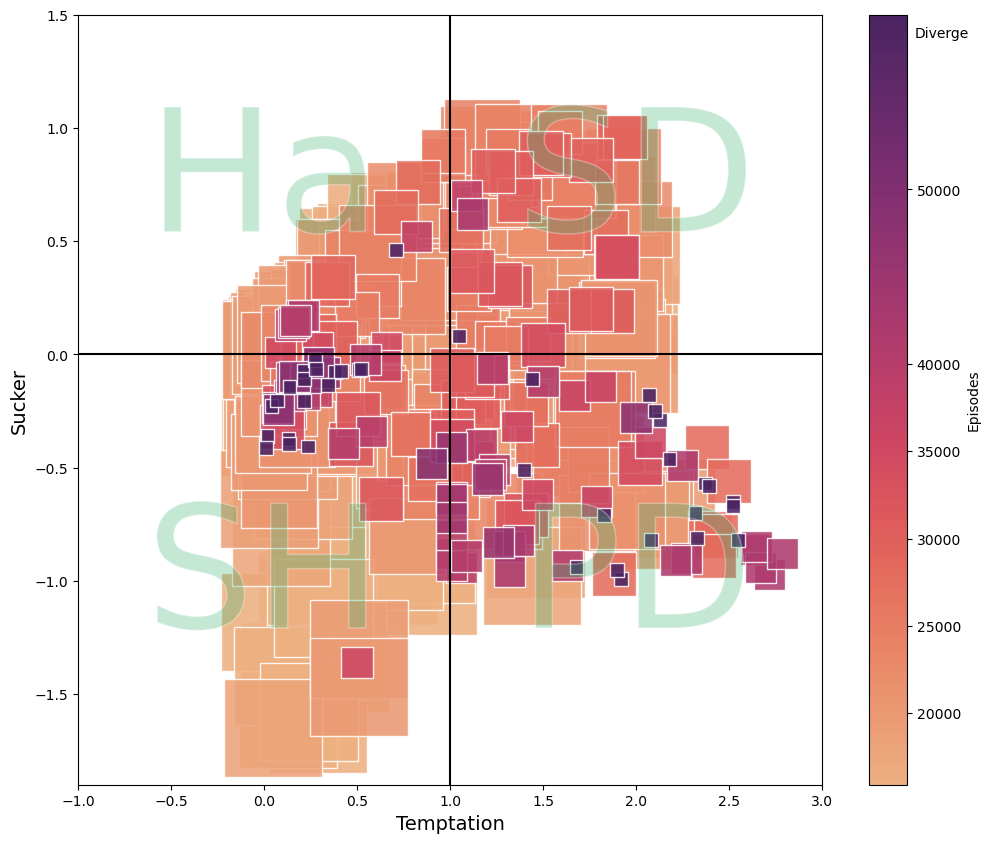

In [334]:
df_all_plot.loc[df_all_plot['network_convergent_episode']>=50000, 'network_convergent_episode'] = 60000

df_all_plot['size'] = 5000
df_all_plot.loc[df_all_plot['network_convergent_episode']>=20000, 'size'] = 3000
df_all_plot.loc[df_all_plot['network_convergent_episode']>=25000, 'size'] = 1000
df_all_plot.loc[df_all_plot['network_convergent_episode']>=35000, 'size'] = 500
df_all_plot.loc[df_all_plot['network_convergent_episode']>=50000, 'size'] = 100


plt.figure(figsize=(12, 10))
ax = sns.scatterplot(data=df_all_plot.sort_values(by=['network_convergent_episode'],ascending=True), y='sucker', x='temptation', 
                hue="network_convergent_episode", size="size", sizes=(100, 5000), 
                linewidth=1, marker='s', alpha=0.88, palette='flare')
lgnd = plt.legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.14, shadow=True)

for i in lgnd.legendHandles:
    i._sizes = [30]
    
plt.vlines(1, -2, 10, 'black')
plt.hlines(0, -10, 10, 'black')

t = ax.text(2, -1, "PD", alpha = .1, animated = True,
       fontsize = 123,      # Size
       ha = "center", # Horizontal alignment
       va = "center")
t.set_path_effects([
#     path_effects.PathPatchEffect(
#         offset=(4, -4), hatch='', facecolor='#708090', alpha=.3, edgecolor='white' ),
    path_effects.PathPatchEffect(
        edgecolor='white', linewidth=1.1, facecolor='#3CB371', alpha=.3)])

t = ax.text(0, -1, "SH", alpha = .5, animated = True,
       fontsize = 123, fontstyle = "normal", color = "grey", ha = "center",  va = "center")
t.set_path_effects([
#     path_effects.PathPatchEffect(
#         offset=(4, -4), hatch='', facecolor='#708090', alpha=.3, edgecolor='white' ),
    path_effects.PathPatchEffect(
        edgecolor='white', linewidth=1.1, facecolor='#3CB371', alpha=.3)])


t = ax.text(0, 0.75, "Ha", alpha = .5, animated = True,
       fontsize = 123, fontstyle = "normal", color = "grey", ha = "center",  va = "center")
t.set_path_effects([
#     path_effects.PathPatchEffect(
#         offset=(4, -4), hatch='', facecolor='#708090', alpha=.3, edgecolor='white' ),
    path_effects.PathPatchEffect(
        edgecolor='white', linewidth=1.1, facecolor='#3CB371', alpha=.3)])

t = ax.text(2, 0.75, "SD",  alpha = .3, animated = True,
       fontsize = 123, color = "grey", ha = "center",  va = "center")
t.set_path_effects([
#     path_effects.PathPatchEffect(
#         offset=(4, -4), hatch='', facecolor='#708090', alpha=.3, edgecolor='white' ),
    path_effects.PathPatchEffect(
        edgecolor='white', linewidth=1.1, facecolor='#3CB371', alpha=.3)])

ax.text(3.5, 1.4, "Diverge", color = "black")

plt.xlim(-1,3)
plt.ylim(-1.9,1.5)
    
norm = plt.Normalize(df_all_plot['network_convergent_episode'].min(), df_all_plot['network_convergent_episode'].max())
sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm, label='Episodes', ticks=[15000,20000,25000,30000,35000,40000,50000])
plt.xlabel('Temptation', fontsize=14)
plt.ylabel('Sucker', fontsize=14)

plt.show()

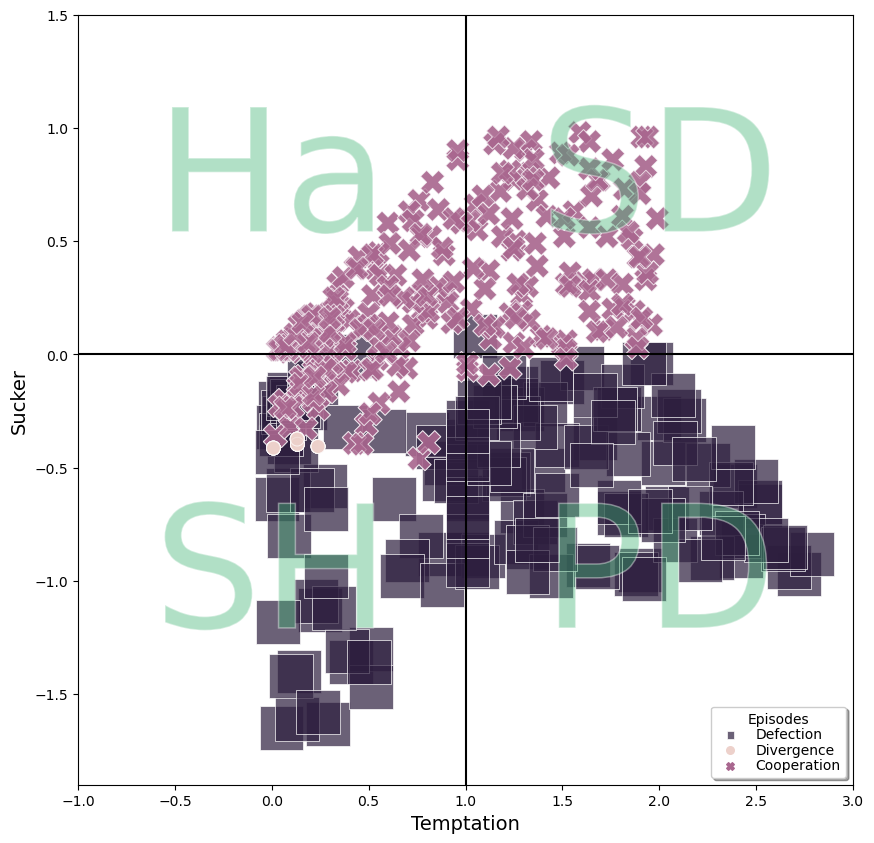

In [24]:
# df_sh_plot.loc[df_sh_plot['strategy_convergent_episode']>=50000, 'strategy_convergent_episode'] = 60000
# df_all_plot = pd.concat([df_all_plot,df_all_plot.loc[df_all_plot.final_strategy==-1]],ignore_index=True)
# df_all_plot = pd.concat([df_all_plot,df_all_plot.loc[df_all_plot.final_strategy==-1]],ignore_index=True)
# df_all_plot = pd.concat([df_all_plot,df_all_plot.loc[df_all_plot.final_strategy==-1]],ignore_index=True)


# df_all_plot = pd.concat([df_all_plot,df_all_plot.loc[df_all_plot.final_strategy==0]],ignore_index=True)

plt.figure(figsize=(10, 10))
ax = sns.scatterplot(data=df_all_plot.sort_values(by=['final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="final_strategy", size="final_strategy", sizes=[100,300,1000], 
                linewidth=0.7, alpha=.7, style="final_strategy", markers=['o','X','s'])

lgnd = plt.legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection', 'Divergence', 'Cooperation'], loc='lower right', shadow=True)

plt.vlines(1, -2, 10, 'black')
plt.hlines(0, -10, 10, 'black')

t = ax.text(2, -1, "PD", alpha = .1, animated = True, fontsize = 123, ha = "center", va = "center")
t.set_path_effects([
    path_effects.PathPatchEffect(
        edgecolor='white', linewidth=1.1, facecolor='#3CB371', alpha=.4)])

t = ax.text(0, -1, "SH", alpha = .5, animated = True,
       fontsize = 123, fontstyle = "normal", color = "grey", ha = "center",  va = "center")
t.set_path_effects([
    path_effects.PathPatchEffect(
        edgecolor='white', linewidth=1.1, facecolor='#3CB371', alpha=.4)])


t = ax.text(0, 0.75, "Ha", alpha = .5, animated = True,
       fontsize = 123, fontstyle = "normal", color = "grey", ha = "center",  va = "center")
t.set_path_effects([
    path_effects.PathPatchEffect(
        edgecolor='white', linewidth=1.1, facecolor='#3CB371', alpha=.4)])

t = ax.text(2, 0.75, "SD",  alpha = .3, animated = True,
       fontsize = 123, color = "grey", ha = "center",  va = "center")
t.set_path_effects([
    path_effects.PathPatchEffect(
        edgecolor='white', linewidth=1.1, facecolor='#3CB371', alpha=.4)])

plt.xlim(-1,3)
plt.ylim(-1.9,1.5)
plt.xlabel('Temptation', fontsize=14)
plt.ylabel('Sucker', fontsize=14)

#change the marker size manually for both lines
for i in lgnd.legendHandles:
    i._sizes = [30]

# Noraml DRQN

PD

In [7]:
reward, temptation, sucker, punishment = generate_payoff_matrix('PD', N=100)
config = {
    'reward': 3, 
    'sucker': 0, 
    'temptation': 5, 
    'punishment': 1, 
    'n_episodes': 10000, 
    'discount': 0.99,
    'play_epsilon': 1,
    'select_epsilon': 1,
    'epsilon_decay': 0.999,
    'min_epsilon': 0.01,
    'alpha': 0.1,
    'n_actions': 2,
    'h': 10,
    'state_repr': 'bi',
    'batch_size': 64,
    'learning_rate': 1e-3/2,
}

df_result_lstm = pd.DataFrame(columns=['strategy_convergent_episode', 'network_convergent_episode', 
                                  'temptation', 'reward', 'punishment', 'sucker', 'final_strategy', 'defection_ratio'])
for idx, val in tqdm(enumerate(reward)):
    config['h'] = 2
    config['n_episodes'] = 50000  # convergent threshold
    config['epsilon_decay'] = 0.995
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        agent, strategy_convergent_episode, network_convergent_episode, _ = TwoAgentSimulation.benchmark_episodic('LSTMQN', config_obj, episodic_flag=False)
#     agent.show()
    df_result_lstm.loc[len(df_result_lstm.index)] = [strategy_convergent_episode, network_convergent_episode, 
                                           config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                           round(float(torch.sum(agent.own_memory[agent.play_times-100:agent.play_times])/100)),
                                           float(torch.sum(agent.own_memory)/agent.play_times)]

df_result_lstm

100it [6:29:39, 233.79s/it]


,strategy_convergent_episode,network_convergent_episode,temptation,reward,punishment,sucker,final_strategy,defection_ratio
0,50156.0,NaN,1.01,1.0,0.0,-0.63,0.0,0.926828
1,50156.0,NaN,1.60,1.0,0.0,-0.06,1.0,0.883643
2,50156.0,NaN,1.27,1.0,0.0,-0.28,1.0,0.844166
3,50156.0,NaN,1.62,1.0,0.0,-0.41,1.0,0.923499
4,46261.0,NaN,2.65,1.0,0.0,-0.85,1.0,0.953585
...,...,...,...,...,...,...,...,...
95,9535.0,10046.0,1.40,1.0,0.0,-0.51,1.0,0.927732
96,18579.0,20811.0,2.02,1.0,0.0,-0.48,1.0,0.942434
97,20691.0,20811.0,2.39,1.0,0.0,-0.58,1.0,0.918168
98,10678.0,11378.0,2.72,1.0,0.0,-0.97,1.0,0.978467


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [6291, 10678, 17781, 21256, 22741, 44491, 46261, 46806, 49334, 'inf']


[Text(0, 0, '6291'),
 Text(1, 0, '10678'),
 Text(2, 0, '17781'),
 Text(3, 0, '21256'),
 Text(4, 0, '22741'),
 Text(5, 0, '44491'),
 Text(6, 0, '46261'),
 Text(7, 0, '46806'),
 Text(8, 0, '49334'),
 Text(9, 0, 'inf')]

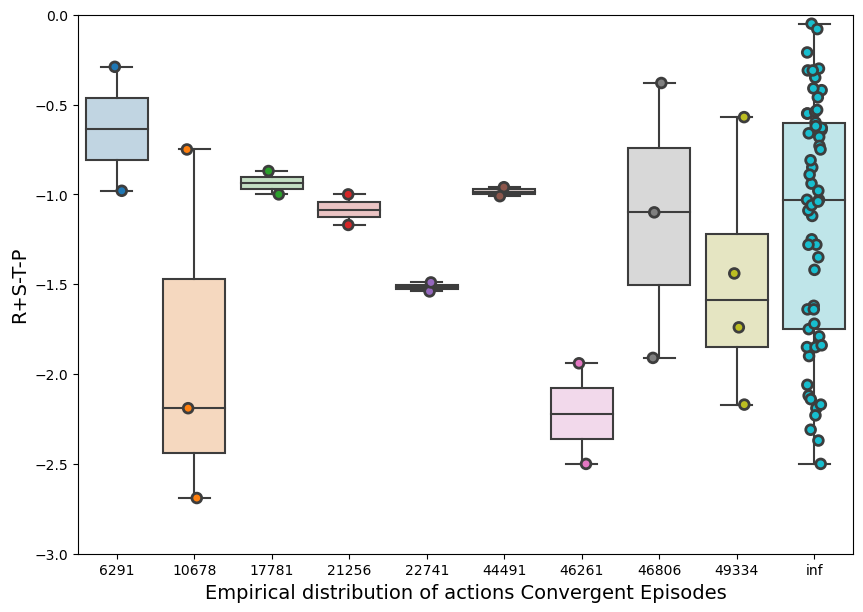

In [84]:
df_result_lstm.loc[df_result_lstm['strategy_convergent_episode'].isnull(), 'strategy_convergent_episode'] = np.inf
df_result_lstm.loc[df_result_lstm['network_convergent_episode'] >= 50000, 'network_convergent_episode'] = np.nan
df_result_lstm.loc[df_result_lstm['network_convergent_episode'].isnull(), 'network_convergent_episode'] = np.inf
df_result_lstm['R+S-T-P'] = df_result_lstm['reward'] + df_result_lstm['sucker'] - df_result_lstm['temptation'] - df_result_lstm['punishment']

df_plot = df_result_lstm.copy()
df_plot = df_plot[df_plot['strategy_convergent_episode'].map(df_plot['strategy_convergent_episode'].value_counts()) > 1]
# df_plot = df_plot.astype({'strategy_convergent_episode':'int'})

# columns = ['Episode', 'Final Strategy', 'R+S-T-P']
# df_s = df_plot[['strategy_convergent_episode','final_strategy', 'R+S-T-P']]
# df_s.columns = columns
# df_s['Convergence'] = 'Empirical distribution of actions'
# df_n = df_plot[['network_convergent_episode','final_strategy', 'R+S-T-P']]
# df_n.columns = columns
# df_n['Convergence'] = 'Strategy'
# df_plot = pd.concat([df_s,df_n],ignore_index=True)

plt.figure(figsize=(10, 7))
ax = sns.boxplot(x='strategy_convergent_episode', y='R+S-T-P', data=df_plot)
sns.stripplot(x='strategy_convergent_episode', y='R+S-T-P', data=df_plot, alpha=1,
              size=7,  linewidth=2)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
plt.xlabel('Empirical distribution of actions Convergent Episodes', fontsize=14)
plt.ylabel('R+S-T-P', fontsize=14)
plt.ylim(-3,0)
# ax.xaxis.grid(True)
# sns.despine(trim=True, left=True)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
xticks_list = []
xticklabels_list = []
for i in ax.get_xticklabels():
    try:
        xticks_list.append(i.get_position()[0])
        xticklabels_list.append(int(float(i.get_text())))
    except: 
        xticklabels_list.append(i.get_text())
print(xticks_list, xticklabels_list)
ax.set_xticks(xticks_list)
ax.set_xticklabels(xticklabels_list)

In [73]:
df_result_lstm.loc[df_result_lstm['strategy_convergent_episode'] >= 50000, 'strategy_convergent_episode'] = np.nan
df_result_lstm.loc[df_result_lstm['network_convergent_episode'] >= 50000, 'network_convergent_episode'] = np.nan
# sum(df_result_lstm['network_convergent_episode'].isnull())
sum(df_result_lstm['strategy_convergent_episode'].isnull())

57

SH

In [8]:
reward, temptation, sucker, punishment = generate_payoff_matrix('SH', N=100)

df_result_lstm_sh = pd.DataFrame(columns=['strategy_convergent_episode', 'network_convergent_episode', 
                                  'temptation', 'reward', 'punishment', 'sucker', 'final_strategy', 'defection_ratio'])
for idx, val in tqdm(enumerate(reward)):
    config['h'] = 2
    config['n_episodes'] = 50000  # convergent threshold
    config['epsilon_decay'] = 0.995
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        agent, strategy_convergent_episode, network_convergent_episode, _ = TwoAgentSimulation.benchmark_episodic('LSTMQN', config_obj, episodic_flag=False)
#     agent.show()
    df_result_lstm_sh.loc[len(df_result_lstm_sh.index)] = [strategy_convergent_episode, network_convergent_episode, 
                                           config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                           round(float(torch.sum(agent.own_memory[agent.play_times-100:agent.play_times])/100)),
                                           float(torch.sum(agent.own_memory)/agent.play_times)]


100it [7:35:31, 273.32s/it]


Text(0, 0.5, 'R+S-T-P')

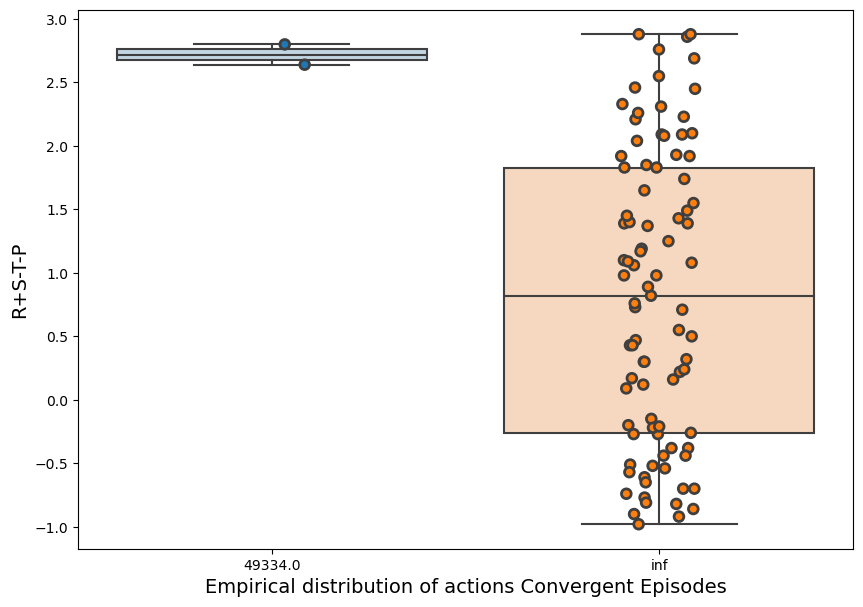

In [86]:
df_result_lstm_sh.loc[df_result_lstm_sh['strategy_convergent_episode'].isnull(), 'strategy_convergent_episode'] = np.inf
df_result_lstm_sh.loc[df_result_lstm_sh['network_convergent_episode'] >= 50000, 'network_convergent_episode'] = np.nan
df_result_lstm_sh.loc[df_result_lstm_sh['network_convergent_episode'].isnull(), 'network_convergent_episode'] = np.inf
df_result_lstm_sh['R+S-T-P'] = df_result_lstm_sh['reward'] + df_result_lstm_sh['sucker'] - df_result_lstm_sh['temptation'] - df_result_lstm_sh['punishment']

df_plot = df_result_lstm_sh.copy()
df_plot = df_plot[df_plot['strategy_convergent_episode'].map(df_plot['strategy_convergent_episode'].value_counts()) > 1]
# df_plot = df_plot.astype({'strategy_convergent_episode':'int'})

# columns = ['Episode', 'Final Strategy', 'R+S-T-P']
# df_s = df_plot[['strategy_convergent_episode','final_strategy', 'R+S-T-P']]
# df_s.columns = columns
# df_s['Convergence'] = 'Empirical distribution of actions'
# df_n = df_plot[['network_convergent_episode','final_strategy', 'R+S-T-P']]
# df_n.columns = columns
# df_n['Convergence'] = 'Strategy'
# df_plot = pd.concat([df_s,df_n],ignore_index=True)

plt.figure(figsize=(10, 7))
ax = sns.boxplot(x='strategy_convergent_episode', y='R+S-T-P', data=df_plot)
sns.stripplot(x='strategy_convergent_episode', y='R+S-T-P', data=df_plot, alpha=1,
              size=7,  linewidth=2)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
plt.xlabel('Empirical distribution of actions Convergent Episodes', fontsize=14)
plt.ylabel('R+S-T-P', fontsize=14)
# plt.ylim(-3,0)
# ax.xaxis.grid(True)
# sns.despine(trim=True, left=True)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

In [80]:
df_result_lstm_sh.loc[df_result_lstm_sh['strategy_convergent_episode'] >= 50000, 'strategy_convergent_episode'] = np.nan
df_result_lstm_sh.loc[df_result_lstm_sh['network_convergent_episode'] >= 50000, 'network_convergent_episode'] = np.nan
sum(df_result_lstm_sh['network_convergent_episode'].isnull())
# sum(df_result_lstm_sh['strategy_convergent_episode'].isnull())

92

# StochasticGameEnvironment

In [9]:
reward, temptation, sucker, punishment = generate_payoff_matrix('PD', N=100)
config = {
    'reward': 3, 
    'sucker': 0, 
    'temptation': 5, 
    'punishment': 1, 
    'n_episodes': 10000, 
    'discount': 0.99,
    'play_epsilon': 1,
    'select_epsilon': 1,
    'epsilon_decay': 0.999,
    'min_epsilon': 0.01,
    'alpha': 0.1,
    'n_actions': 2,
    'h': 10,
    'state_repr': 'bi',
    'batch_size': 64,
    'learning_rate': 1e-3,
}

df_result_sg = pd.DataFrame(columns=['strategy_convergent_episode', 'network_convergent_episode', 
                                  'temptation', 'reward', 'punishment', 'sucker', 'final_strategy', 'defection_ratio'])
for idx, val in tqdm(enumerate(reward)):
    config['h'] = 2
    config['n_episodes'] = 50000  # convergent threshold
    config['epsilon_decay'] = 0.995
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        agent, strategy_convergent_episode, network_convergent_episode, _ = TwoAgentSimulation.benchmark_episodic('LSTMQN', config_obj, episodic_flag=True, sg_flag=True)
#     agent.show()
    df_result_sg.loc[len(df_result_sg.index)] = [strategy_convergent_episode, network_convergent_episode, 
                                           config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                           round(float(torch.sum(agent.own_memory[agent.play_times-100:agent.play_times])/100)),
                                           float(torch.sum(agent.own_memory)/agent.play_times)]


100it [2:30:02, 90.02s/it]


In [10]:
df_result_sg

,strategy_convergent_episode,network_convergent_episode,temptation,reward,punishment,sucker,final_strategy,defection_ratio
0,37565.0,39830.0,1.01,1.0,0.0,-0.63,1.0,0.898895
1,47261.0,49334.0,1.60,1.0,0.0,-0.06,0.0,0.257753
2,15710.0,18906.0,1.27,1.0,0.0,-0.28,1.0,0.860520
3,29807.0,47474.0,1.62,1.0,0.0,-0.41,1.0,0.938535
4,29807.0,NaN,2.65,1.0,0.0,-0.85,1.0,0.958111
...,...,...,...,...,...,...,...,...
95,17485.0,19848.0,1.40,1.0,0.0,-0.51,1.0,0.860238
96,29807.0,34093.0,2.02,1.0,0.0,-0.48,1.0,0.913149
97,29807.0,NaN,2.39,1.0,0.0,-0.58,1.0,0.958111
98,29807.0,41583.0,2.72,1.0,0.0,-0.97,1.0,0.950148


Text(0, 0.5, 'R+S-T-P')

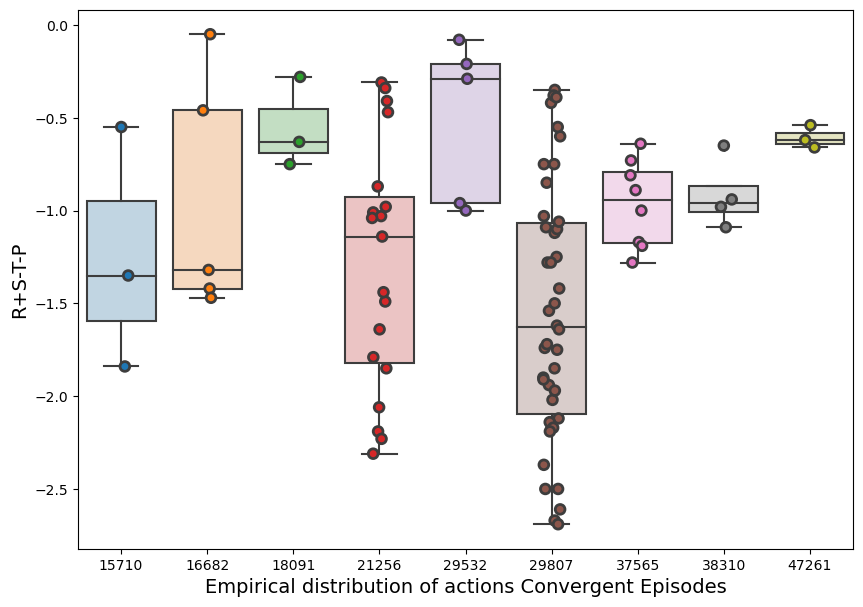

In [52]:
df_result_sg.loc[df_result_sg['strategy_convergent_episode'].isnull(), 'strategy_convergent_episode'] = np.inf
df_result_sg.loc[df_result_sg['network_convergent_episode'] >= 50000, 'network_convergent_episode'] = np.nan
df_result_sg.loc[df_result_sg['network_convergent_episode'].isnull(), 'network_convergent_episode'] = np.inf
df_result_sg['R+S-T-P'] = df_result_sg['reward'] + df_result_sg['sucker'] - df_result_sg['temptation'] - df_result_sg['punishment']

df_plot = df_result_sg.copy()
df_plot = df_plot[df_plot['strategy_convergent_episode'].map(df_plot['strategy_convergent_episode'].value_counts()) > 2]
df_plot = df_plot.astype({'strategy_convergent_episode':'int'})

# columns = ['Episode', 'Final Strategy', 'R+S-T-P']
# df_s = df_plot[['strategy_convergent_episode','final_strategy', 'R+S-T-P']]
# df_s.columns = columns
# df_s['Convergence'] = 'Empirical distribution of actions'
# df_n = df_plot[['network_convergent_episode','final_strategy', 'R+S-T-P']]
# df_n.columns = columns
# df_n['Convergence'] = 'Strategy'
# df_plot = pd.concat([df_s,df_n],ignore_index=True)

plt.figure(figsize=(10, 7))
ax = sns.boxplot(x='strategy_convergent_episode', y='R+S-T-P', data=df_plot)
sns.stripplot(x='strategy_convergent_episode', y='R+S-T-P', data=df_plot, alpha=1,
              size=7,  linewidth=2)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
plt.xlabel('Empirical distribution of actions Convergent Episodes', fontsize=14)
plt.ylabel('R+S-T-P', fontsize=14)
# plt.ylim(-3,0)
# ax.xaxis.grid(True)
# sns.despine(trim=True, left=True)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

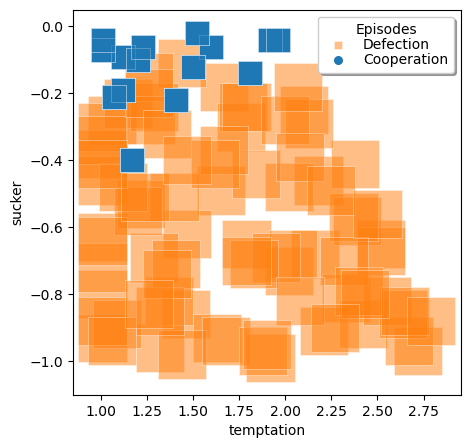

In [63]:
df_sh_plot = df_result_sg.copy()
df_sh_plot.temptation = df_sh_plot.temptation/df_sh_plot.reward
df_sh_plot.sucker = df_sh_plot.sucker/df_sh_plot.reward
df_sh_plot['new_reward'] = 1.0

df_sh_plot2 = df_sh_plot.copy()
df_sh_plot2.loc[df_sh_plot2['strategy_convergent_episode']>=50000, 'final_strategy'] = -1
df_sh_plot2 = pd.concat([df_sh_plot2,df_sh_plot2.loc[df_sh_plot2.final_strategy==-1]],ignore_index=True)
df_sh_plot2 = pd.concat([df_sh_plot2,df_sh_plot2.loc[df_sh_plot2.final_strategy==-1]],ignore_index=True)
df_sh_plot2 = pd.concat([df_sh_plot2,df_sh_plot2.loc[df_sh_plot2.final_strategy==-1]],ignore_index=True)
df_sh_plot2 = pd.concat([df_sh_plot2,df_sh_plot2.loc[df_sh_plot2.final_strategy==-1]],ignore_index=True)
df_sh_plot2 = pd.concat([df_sh_plot2,df_sh_plot2.loc[df_sh_plot2.final_strategy==0]],ignore_index=True)
df_sh_plot2 = pd.concat([df_sh_plot2,df_sh_plot2.loc[df_sh_plot2.final_strategy==0]],ignore_index=True)
df_sh_plot2 = pd.concat([df_sh_plot2,df_sh_plot2.loc[df_sh_plot2.final_strategy==0]],ignore_index=True)

plt.figure(figsize=(5, 5))
ax = sns.scatterplot(data=df_sh_plot2.sort_values(by=['final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="final_strategy", size="final_strategy", sizes=[300,1200], 
                linewidth=0.5, alpha=.5, marker='s')

# markerprops = dict(markeredgewidth=1.25, markeredgecolor='black', markersize=7, markerfacecolor='none')
# handles, labels = ax.get_legend_handles_labels()
# for h in handles:
#     h.set(**markerprops)
    
lgnd = plt.legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection', 'Cooperation'], loc='upper right', shadow=True)
plt.xlim(0.85,2.95)
plt.ylim(-1.1,0.05)

#change the marker size manually for both lines
for i in lgnd.legendHandles:
    i._sizes = [30]


In [82]:
df_result_sg.loc[df_result_sg['strategy_convergent_episode'] >= 50000, 'strategy_convergent_episode'] = np.nan
df_result_sg.loc[df_result_sg['network_convergent_episode'] >= 50000, 'network_convergent_episode'] = np.nan
# sum(df_result_sg['network_convergent_episode'].isnull())
sum(df_result_sg['strategy_convergent_episode'].isnull())

0

# DDQN

In [ ]:
reward, temptation, sucker, punishment = generate_payoff_matrix('PD', N=100)

df_result_ddqn_pd = pd.DataFrame(columns=['strategy_convergent_episode', 'network_convergent_episode', 
                                  'temptation', 'reward', 'punishment', 'sucker', 'final_strategy', 'defection_ratio'])
for idx, val in tqdm(enumerate(reward)):
    config['h'] = 5
    config['n_episodes'] = 50000  # convergent threshold
    config['epsilon_decay'] = 0.995
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        agent, strategy_convergent_episode, network_convergent_episode, _ = TwoAgentSimulation.benchmark_episodic('LSTMQN', config_obj, episodic_flag=True, method='DDQN')
#     agent.show()
    df_result_ddqn_pd.loc[len(df_result_ddqn_pd.index)] = [strategy_convergent_episode, network_convergent_episode, 
                                           config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                           round(float(torch.sum(agent.own_memory[agent.play_times-100:agent.play_times])/100)),
                                           float(torch.sum(agent.own_memory)/agent.play_times)]


In [ ]:
reward, temptation, sucker, punishment = generate_payoff_matrix('SH', N=100)

df_result_ddqn_sh = pd.DataFrame(columns=['strategy_convergent_episode', 'network_convergent_episode', 
                                  'temptation', 'reward', 'punishment', 'sucker', 'final_strategy', 'defection_ratio'])
for idx, val in tqdm(enumerate(reward)):
    config['h'] = 5
    config['n_episodes'] = 50000  # convergent threshold
    config['epsilon_decay'] = 0.995
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        agent, strategy_convergent_episode, network_convergent_episode, _ = TwoAgentSimulation.benchmark_episodic('LSTMQN', config_obj, episodic_flag=True, method='DDQN')
#     agent.show()
    df_result_ddqn_sh.loc[len(df_result_ddqn_sh.index)] = [strategy_convergent_episode, network_convergent_episode, 
                                           config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                           round(float(torch.sum(agent.own_memory[agent.play_times-100:agent.play_times])/100)),
                                           float(torch.sum(agent.own_memory)/agent.play_times)]


In [ ]:
reward, temptation, sucker, punishment = generate_payoff_matrix('PD', N=100)

df_result_ddqn_SG = pd.DataFrame(columns=['strategy_convergent_episode', 'network_convergent_episode', 
                                  'temptation', 'reward', 'punishment', 'sucker', 'final_strategy', 'defection_ratio'])
for idx, val in tqdm(enumerate(reward)):
    config['h'] = 5
    config['n_episodes'] = 50000  # convergent threshold
    config['epsilon_decay'] = 0.995
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        agent, strategy_convergent_episode, network_convergent_episode, _ = TwoAgentSimulation.benchmark_episodic('LSTMQN', config_obj, episodic_flag=True, sg_flag=True, method='DDQN')
#     agent.show()
    df_result_ddqn_SG.loc[len(df_result_ddqn_SG.index)] = [strategy_convergent_episode, network_convergent_episode, 
                                           config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                           round(float(torch.sum(agent.own_memory[agent.play_times-100:agent.play_times])/100)),
                                           float(torch.sum(agent.own_memory)/agent.play_times)]


[[34.070847 27.349901]
 [34.057312 27.338995]]


torch.Size([1, 5, 2])